In [1]:

import uproot
import numpy as np
import mplhep as hep
import dask_awkward as dk
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import vector
import random
import time 
import hist
from uncertainties import unumpy as unp
import os

In [2]:

#########################################################################################################################################################
def compute_rapidity(pt, eta, mass):
    pz=pt*np.sinh(eta)
    e=np.sqrt(pt**2 + mass**2 + (pt * np.sinh(eta))**2)
    return 0.5 * np.log((e + pz) / (e - pz))

#########################################################################################################################################################


def comp_hel_basis(top, tbar, top_rap, atop_rap):
    ttbar_frame = top + tbar
    boosted_top = top.boostCM_of(ttbar_frame)
    k_axis = boosted_top.to_xyz().unit()

    theta = k_axis.theta
    sin_theta = np.sin(theta)
    sin_theta = np.where(np.abs(sin_theta) < 1e-5, 1e-5, sin_theta)

    sign_y = np.sign(np.cos(theta))
    sign_d = np.where(np.abs(top_rap) >= np.abs(atop_rap), 1.0, -1.0)

    z_axis = vector.obj(x=0, y=0, z=1)

    axis_coeff = sign_d * sign_y / sin_theta
    r_axis = (axis_coeff * (z_axis - (k_axis * np.cos(theta)))).unit()
    n_axis = (axis_coeff * z_axis.cross(k_axis)).unit()

    return k_axis, r_axis, n_axis



#########################################################################################################################################################

def spincorr_calc(basis, top, tbar, l, lbar):
    boosted_top = top.boostCM_of(top.add(tbar))
    boosted_lbar = lbar.boostCM_of(top.add(tbar)).boostCM_of(boosted_top)
    boosted_tbar = tbar.boostCM_of(top.add(tbar))
    boosted_l = l.boostCM_of(top.add(tbar)).boostCM_of(boosted_tbar)
    b1k = np.cos(boosted_lbar.deltaangle(basis[0]).to_numpy())
    b2k = np.cos(boosted_l.deltaangle(-1 * basis[0]).to_numpy())
    b1r = np.cos(boosted_lbar.deltaangle(basis[1]).to_numpy())
    b2r = np.cos(boosted_l.deltaangle(-1 * basis[1]).to_numpy())
    b1n = np.cos(boosted_lbar.deltaangle(basis[2]).to_numpy())
    b2n = np.cos(boosted_l.deltaangle(-1 * basis[2]).to_numpy())
    c_kk = b1k * b2k
    c_kr = b1k * b2r
    c_kn = b1k * b2n
    c_rk = b1r * b2k
    c_rr = b1r * b2r
    c_rn = b1r * b2n
    c_nk = b1n * b2k
    c_nr = b1n * b2r
    c_nn = b1n * b2n
    ll_cHel = ((boosted_l.to_xyz()).unit()).dot((boosted_lbar.to_xyz()).unit())
    ll_delta_phi = np.abs(l.phi - lbar.phi).to_numpy()
    ll_delta_eta = np.abs(l.eta - lbar.eta).to_numpy()
    ll_delta_R = np.sqrt((l.phi - lbar.phi)**2 + (l.eta - lbar.eta)**2).to_numpy()
    cP_kr = c_kr + c_rk
    cM_kr = c_kr - c_rk
    cP_kn = c_kn + c_nk
    cM_kn = c_kn - c_nk
    cP_rn = c_rn + c_nr
    cM_rn = c_rn - c_nr
    return b1k, b2k, b1r, b2r, b1n, b2n, c_kk, c_kr, c_kn, c_rk, c_rr, c_rn, c_nk, c_nr, c_nn, ll_cHel, ll_delta_phi, ll_delta_eta, ll_delta_R, cP_kr, cM_kr, cP_kn, cM_kn, cP_rn, cM_rn

def find_true_indices(jagged_array):
    # Convert None to False
    cleaned_array = ak.fill_none(jagged_array, False)
    # Create a mask for True values
    mask = cleaned_array == True
    # Get the indices of True values in each subarray
    true_indices = ak.local_index(cleaned_array)[mask]
    
    # Print the results
    #print("True values indices within subarrays:", true_indices)
    return true_indices

#########################################################################################################################################################

# Function to find common numbers in two jagged arrays
def find_common_elements(jagged_array1, jagged_array2):
    common_elements = ak.Array([np.intersect1d(subarray1, subarray2) for subarray1, subarray2 in zip(jagged_array1, jagged_array2)])
    return common_elements

#########################################################################################################################################################

def create_variable_axes(label, low, high, divisions):
    return hist.axis.Variable(np.linspace(low, high, divisions), label=label, overflow=True)

#########################################################################################################################################################

def create_histogram(ax, label):
    return hist.Hist(ax, label=label, storage=hist.storage.Weight())

#########################################################################################################################################################
#########################################################################################################################################################

# this definition is global 
variable_axes = {
    'l_pt': create_variable_axes(r'Lepton $p_T$ $(GeV)$', 0, 400, 81),
    'l_eta': create_variable_axes(r'Lepton $\eta$', -2*np.pi, 2*np.pi, 21),
    'l_phi': create_variable_axes(r'Lepton $\varphi$', -np.pi, np.pi, 21),
    'l_mass': create_variable_axes(r'Lepton Mass $(GeV)$', 0, 400, 81),
    'lbar_pt': create_variable_axes(r'Anti-Lepton $p_T$ $(GeV)$', 0, 400, 81),
    'lbar_eta': create_variable_axes(r'Anti-Lepton $\eta$', -2*np.pi, 2*np.pi, 21),
    'lbar_phi': create_variable_axes(r'Anti-Lepton $\varphi$', -np.pi, np.pi, 21),
    'lbar_mass': create_variable_axes(r'Anti-Lepton Mass $(GeV)$', 0, 400, 81),        
}

titles = ["gen_b1k", "gen_b2k", "gen_b1r", "gen_b2r", "gen_b1n", "gen_b2n","gen_c_kk", "gen_c_kr", "gen_c_kn", "gen_c_rk", "gen_c_rr", "gen_c_rn","gen_c_nk", "gen_c_nr", "gen_c_nn", "gen_ll_cHel", "gen_llbar_delta_phi","gen_llbar_delta_eta", "gen_llbar_delta_R", "gen_cP_kr", "gen_cM_kr","gen_cP_kn", "gen_cM_kn", "gen_cP_rn", "gen_cM_rn"]
#titles=["gen_c_kk","gen_b1k"]
gen_spincorr_axes = {
    'gen_b1k': create_variable_axes(r'Generated Spin Correlation Coeff. $B_{1k}$', -1, 1, 9),
    'gen_b2k': create_variable_axes(r'Generated Spin Correlation Coeff. $B_{2k}$', -1, 1, 9),
    'gen_b1r': create_variable_axes(r'Generated Spin Correlation Coeff. $B_{1r}$', -1, 1, 9),
    'gen_b2r': create_variable_axes(r'Generated Spin Correlation Coeff. $B_{2r}$', -1, 1, 9),
    'gen_b1n': create_variable_axes(r'Generated Spin Correlation Coeff. $B_{1n}$', -1, 1, 9),
    'gen_b2n': create_variable_axes(r'Generated Spin Correlation Coeff. $B_{2n}$', -1, 1, 9),
    'gen_c_kk': create_variable_axes(r'Generated Spin Correlation Coeff. $C_{kk}$', -1, 1, 9),
    'gen_c_rr': create_variable_axes(r'Generated Spin Correlation Coeff. $C_{rr}$', -1, 1, 9),
    'gen_c_nn': create_variable_axes(r'Generated Spin Correlation Coeff. $C_{nn}$', -1, 1, 9),
    'gen_c_rk': create_variable_axes(r'Generated Spin Correlation Coeff. $C_{rk}$', -1, 1, 9),
    'gen_c_kr': create_variable_axes(r'Generated Spin Correlation Coeff. $C_{kr}$', -1, 1, 9),
    'gen_c_nr': create_variable_axes(r'Generated Spin Correlation Coeff. $C_{nr}$', -1, 1, 9),
    'gen_c_rn': create_variable_axes(r'Generated Spin Correlation Coeff. $C_{rn}$', -1, 1, 9),
    'gen_c_nk': create_variable_axes(r'Generated Spin Correlation Coeff. $C_{nk}$', -1, 1, 9),
    'gen_c_kn': create_variable_axes(r'Generated Spin Correlation Coeff. $C_{kn}$', -1, 1, 9),
    'gen_c_rj': create_variable_axes(r'Generated Spin Correlation Coeff. $C_{rj}$', -1, 1, 9),
    'gen_c_jr': create_variable_axes(r'Generated Spin Correlation Coeff. $C_{jr}$', -1, 1, 9),
    'gen_ll_cHel': create_variable_axes(r'Generated Lepton-AntiLepton $cos(\varphi)$ Helicity', -1, 1, 9),
    'gen_llbar_delta_phi': create_variable_axes(r'Generated Lepton-AntiLepton $\delta \phi$', 0, 10, 9),
    'gen_llbar_delta_eta': create_variable_axes(r'Generated Lepton-AntiLepton $\delta \eta$', 0, 10, 9),
    'gen_llbar_delta_R': create_variable_axes(r'Generated Lepton-AntiLepton $\delta R$', 0, 10, 9),
    'gen_cP_kr': create_variable_axes(r'Generated Spin Correlation Coeff. $c^r_1c^k_2+c^k_1c^r_2$', -1, 1, 9),
    'gen_cM_kr': create_variable_axes(r'Generated Spin Correlation Coeff. $c^r_1c^k_2-c^k_1c^r_2$', -1, 1, 9),
    'gen_cP_kn': create_variable_axes(r'Generated Spin Correlation Coeff. $c^n_1c^k_2+c^k_1c^n_2$', -1, 1, 9),
    'gen_cM_kn': create_variable_axes(r'Generated Spin Correlation Coeff. $c^n_1c^k_2-c^k_1c^n_2$', -1, 1, 9),
    'gen_cP_rn': create_variable_axes(r'Generated Spin Correlation Coeff. $c^n_1c^r_2+c^r_1c^n_2$', -1, 1, 9),
    'gen_cM_rn': create_variable_axes(r'Generated Spin Correlation Coeff. $c^n_1c^r_2-c^r_1c^n_2$', -1, 1, 9),
}

In [ ]:
# Directory containing your ROOT files
directory_path = '/depot/cms/top/bhanda25/EFT_ML/nanoaod_central_2017/'

# List all .root files in the directory
file_paths = [os.path.join(directory_path, filename) for filename in os.listdir(directory_path) if filename.endswith('.root')]

# Open each ROOT file and extract the 'Events' TTree (adjust the path if necessary)
trees = [uproot.open(file_path)['Events'] for file_path in file_paths]

# Concatenate the TTrees from all files into a single TTree
combined_tree = uproot.concatenate(trees)

In [10]:
import uproot
nanogen = uproot.open('/eos/purdue/store/user/lingqian/nanogen_TT01j2l_SM/nanogen_TT01j2l_SM_500k.root')
#nanogen_sm = uproot.open('/depot/cms/top/bhanda25/EFT/nanoaod_ND/NAOD-00000_10211.root')
#nanogen_sm= uproot.open('root://lyoeos.in2p3.fr:1094//store/mc/RunIISummer20UL17NanoAODv9/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/270000/0D1583EC-5199-934D-81D7-491CB7631105.root')
#nanogen = uproot.open('/depot/cms/top/bhanda25/EFT_ML/nanoaod_central_2017/ED03C241-B315-464B-942C-A45CE451C354.root')


In [336]:
gen_weight=nanogen['Events']['Generator_weight'].array()

In [11]:
genpart_pt = nanogen['Events']['GenPart_pt'].array()
genpart_eta = nanogen['Events']['GenPart_eta'].array()
genpart_phi = nanogen['Events']['GenPart_phi'].array()
genpart_mass = nanogen['Events']['GenPart_mass'].array()
genpart_pid = nanogen['Events']['GenPart_pdgId'].array()
genpart_mother = nanogen['Events']['GenPart_genPartIdxMother'].array()
gen_weight=nanogen['Events']['Generator_weight'].array()

In [242]:
# Identify particle masks
is_top = genpart_pid == 6
is_antitop = genpart_pid == -6
is_wplus = genpart_pid == 24
is_wminus = genpart_pid == -24
is_bottom = genpart_pid == 5
is_antibottom = genpart_pid == -5

# Get local indices
indices = ak.local_index(genpart_pid)

# Get top and antitop indices
top_indices = indices[is_top]
antitop_indices = indices[is_antitop]

# Get W+ and W- mother indices
wplus_mothers = genpart_mother[is_wplus]
wminus_mothers = genpart_mother[is_wminus]

# Match top → W+ and antitop → W-
top_with_wplus_daughter_mask = ak.any(top_indices[:, :, None] == wplus_mothers[:, None, :], axis=-1)
antitop_with_wminus_daughter_mask = ak.any(antitop_indices[:, :, None] == wminus_mothers[:, None, :], axis=-1)

# Now find W+ and W- indices
Wplus_indices = indices[is_wplus]
Wminus_indices = indices[is_wminus]

# Step 3: For each particle, check if its mother is a W⁺ or W⁻ (element-wise)
mother_is_Wplus = ak.any(genpart_mother[:, None] == Wplus_indices, axis=1)
mother_is_Wminus = ak.any(genpart_mother[:, None] == Wminus_indices, axis=1)

# Require both decays
has_two_tops = (ak.sum(top_with_wplus_daughter_mask, axis=1) +
                ak.sum(antitop_with_wminus_daughter_mask, axis=1)) == 2

In [262]:

# W+ and W- lepton daughter masks for all dileptonic channels (ee, mumu, emu)
Wplus_with_lbar_daughters_mask = (
    (genpart_pid[mother_is_Wplus] == -11) |  # e+
    (genpart_pid[mother_is_Wplus] == -13)    # μ+
)

Wminus_with_l_daughters_mask = (
    (genpart_pid[mother_is_Wminus] == 11) |   # e−
    (genpart_pid[mother_is_Wminus] == 13)     # μ−
)


has_two_leptons = (ak.sum(Wplus_with_lbar_daughters_mask, axis=1) +
                   ak.sum(Wminus_with_l_daughters_mask, axis=1)) == 2

dilepton_event_mask = has_two_tops & has_two_leptons


In [317]:


genvec = vector.Array(ak.zip({
    "pt": genpart_pt,
    "eta": genpart_eta,
    "phi": genpart_phi,
    "mass": genpart_mass,
}))

# Extract vector components
E = genvec.E
px = genvec.px
py = genvec.py
pz = genvec.pz


In [321]:
# Use already extracted E, px, py, pz arrays from genvec
# (assuming these came from clean_pt, clean_eta, clean_phi, clean_mass)

# Extract top and antitop quark momenta
top_E  = E[is_top][top_with_wplus_daughter_mask][dilepton_event_mask]
top_px = px[is_top][top_with_wplus_daughter_mask][dilepton_event_mask]
top_py = py[is_top][top_with_wplus_daughter_mask][dilepton_event_mask]
top_pz = pz[is_top][top_with_wplus_daughter_mask][dilepton_event_mask]

tbar_E  = E[is_antitop][antitop_with_wminus_daughter_mask][dilepton_event_mask]
tbar_px = px[is_antitop][antitop_with_wminus_daughter_mask][dilepton_event_mask]
tbar_py = py[is_antitop][antitop_with_wminus_daughter_mask][dilepton_event_mask]
tbar_pz = pz[is_antitop][antitop_with_wminus_daughter_mask][dilepton_event_mask]

# Extract leptons
l_E  = E[mother_is_Wminus][Wminus_with_l_daughters_mask][dilepton_event_mask]
l_px = px[mother_is_Wminus][Wminus_with_l_daughters_mask][dilepton_event_mask]
l_py = py[mother_is_Wminus][Wminus_with_l_daughters_mask][dilepton_event_mask]
l_pz = pz[mother_is_Wminus][Wminus_with_l_daughters_mask][dilepton_event_mask]

lbar_E  = E[mother_is_Wplus][Wplus_with_lbar_daughters_mask][dilepton_event_mask]
lbar_px = px[mother_is_Wplus][Wplus_with_lbar_daughters_mask][dilepton_event_mask]
lbar_py = py[mother_is_Wplus][Wplus_with_lbar_daughters_mask][dilepton_event_mask]
lbar_pz = pz[mother_is_Wplus][Wplus_with_lbar_daughters_mask][dilepton_event_mask]


In [273]:
# Build event-level mask to remove empty sublists
valid_events = (
    (ak.num(top_E) > 0) & (ak.num(tbar_E) > 0) &
    (ak.num(l_E) > 0) & (ak.num(lbar_E) > 0)
)

# Apply mask to all kinematic arrays
top_E, top_px, top_py, top_pz       = top_E[valid_events], top_px[valid_events], top_py[valid_events], top_pz[valid_events]
tbar_E, tbar_px, tbar_py, tbar_pz   = tbar_E[valid_events], tbar_px[valid_events], tbar_py[valid_events], tbar_pz[valid_events]
l_E, l_px, l_py, l_pz               = l_E[valid_events], l_px[valid_events], l_py[valid_events], l_pz[valid_events]
lbar_E, lbar_px, lbar_py, lbar_pz   = lbar_E[valid_events], lbar_px[valid_events], lbar_py[valid_events], lbar_pz[valid_events]



In [324]:
# Build 4-vectors
tops = vector.zip({'E': top_E, 'px': top_px, 'py': top_py, 'pz': top_pz})
tbars = vector.zip({'E': tbar_E, 'px': tbar_px, 'py': tbar_py, 'pz': tbar_pz})
ls = vector.zip({'E': l_E, 'px': l_px, 'py': l_py, 'pz': l_pz})
lbars = vector.zip({'E': lbar_E, 'px': lbar_px, 'py': lbar_py, 'pz': lbar_pz})

In [333]:


# Compute spin correlation observables in one step
ttbar_frame = tops + tbars
boosted_tops = tops.boostCM_of(ttbar_frame)
boosted_tbars = tbars.boostCM_of(ttbar_frame)
boosted_ls = ls.boostCM_of(ttbar_frame).boostCM_of(boosted_tbars)
boosted_lbars = lbars.boostCM_of(ttbar_frame).boostCM_of(boosted_tops)
p_axis = vector.obj(x=0, y=0, z=1)
k_axis = boosted_tops.to_xyz().unit()
scattering_angle = k_axis.theta
sin_scat_angle = np.sin(scattering_angle)
sin_scat_angle = np.where(np.abs(sin_scat_angle) < 1e-5, 1e-5, sin_scat_angle)
axis_coeff = np.sign(np.cos(scattering_angle)) / np.abs(sin_scat_angle)
r_axis = axis_coeff * (p_axis - (k_axis * np.cos(scattering_angle)))
n_axis = axis_coeff * p_axis.cross(k_axis)

ll_cHel = np.cos(boosted_lbars.deltaangle(boosted_ls).to_numpy()).reshape(-1)
cos_theta1k = np.cos(boosted_lbars.deltaangle(k_axis).to_numpy())
cos_theta1r = np.cos(boosted_lbars.deltaangle(r_axis).to_numpy())
cos_theta1n = np.cos(boosted_lbars.deltaangle(n_axis).to_numpy())
cos_theta2k = np.cos(boosted_ls.deltaangle(-1 * k_axis).to_numpy())
cos_theta2r = np.cos(boosted_ls.deltaangle(-1 * r_axis).to_numpy())
cos_theta2n = np.cos(boosted_ls.deltaangle(-1 * n_axis).to_numpy())

ttbar_mass = (tops + tbars).M.to_numpy().reshape(-1)
B1 = np.stack((cos_theta1k, cos_theta1r, cos_theta1n), axis=1)
B2 = np.stack((cos_theta2k, cos_theta2r, cos_theta2n), axis=1)
# Compute individual C_ij components
c_kk = cos_theta1k * cos_theta2k
c_kr = cos_theta1k * cos_theta2r
c_kn = cos_theta1k * cos_theta2n
c_rk = cos_theta1r * cos_theta2k
c_rr = cos_theta1r * cos_theta2r
c_rn = cos_theta1r * cos_theta2n
c_nk = cos_theta1n * cos_theta2k
c_nr = cos_theta1n * cos_theta2r
c_nn = cos_theta1n * cos_theta2n

# Stack them row-wise first, then column-wise, then transpose
C = np.stack([
    np.stack([c_kk, c_kr, c_kn], axis=1),  # shape (n_events, 3)
    np.stack([c_rk, c_rr, c_rn], axis=1),
    np.stack([c_nk, c_nr, c_nn], axis=1)
], axis=1)  # shape will now be (n_events, 3, 3)


In [334]:
B1

array([[[ 0.81202269],
        [-0.52846965],
        [-0.2476671 ]],

       [[ 0.75264364],
        [-0.60655428],
        [ 0.25616368]],

       [[ 0.66641712],
        [-0.2850936 ],
        [ 0.68891922]],

       ...,

       [[-0.53947037],
        [ 0.20688505],
        [-0.81619253]],

       [[-0.39969194],
        [-0.91389545],
        [-0.07100267]],

       [[-0.77646905],
        [-0.5913103 ],
        [-0.21782586]]])

In [337]:
a = nanogen['Events']['Generator_weight'].array()
a[dilepton_event_mask]

<Array [1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1] type='96757 * float32'>

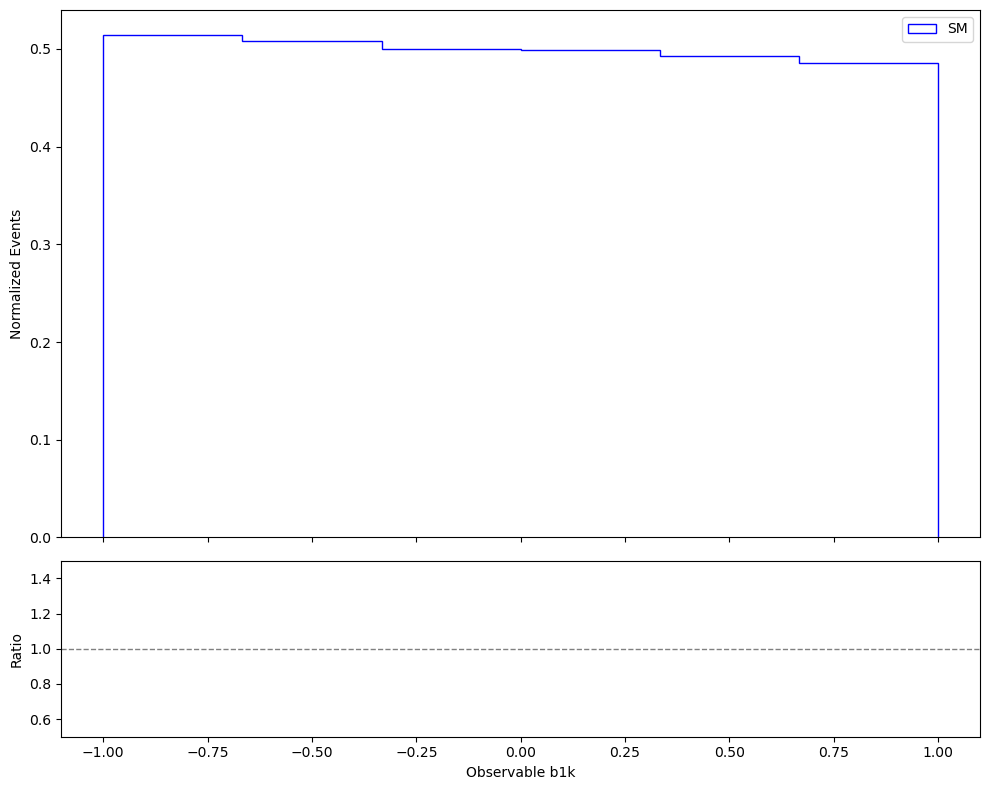

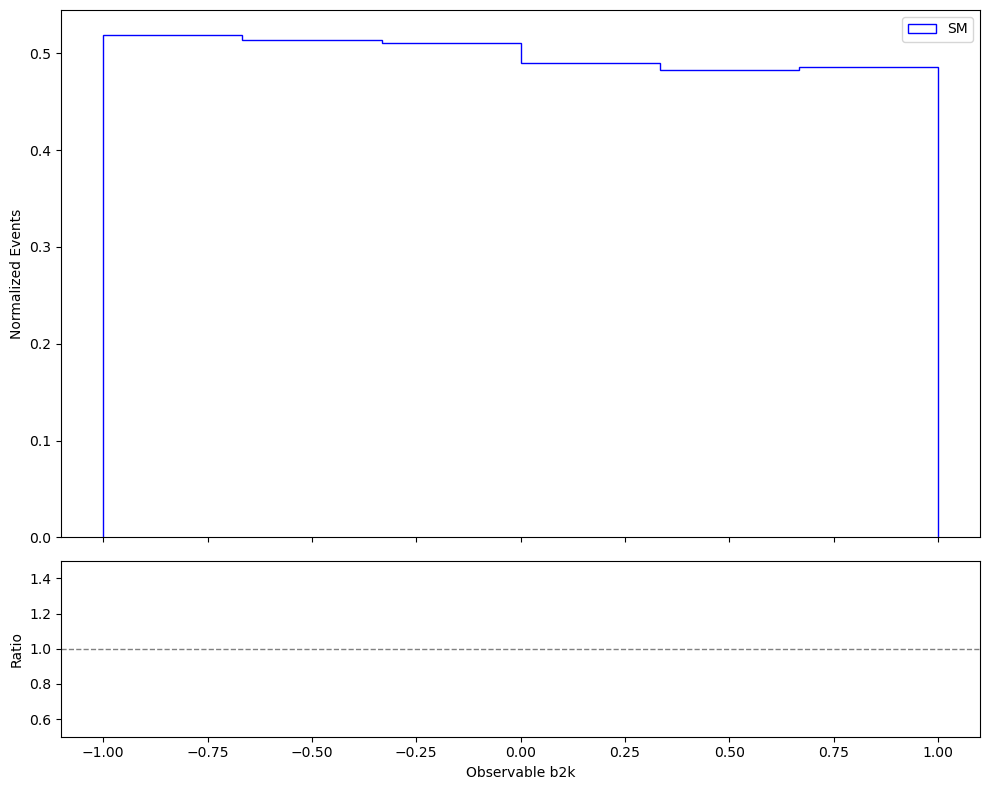

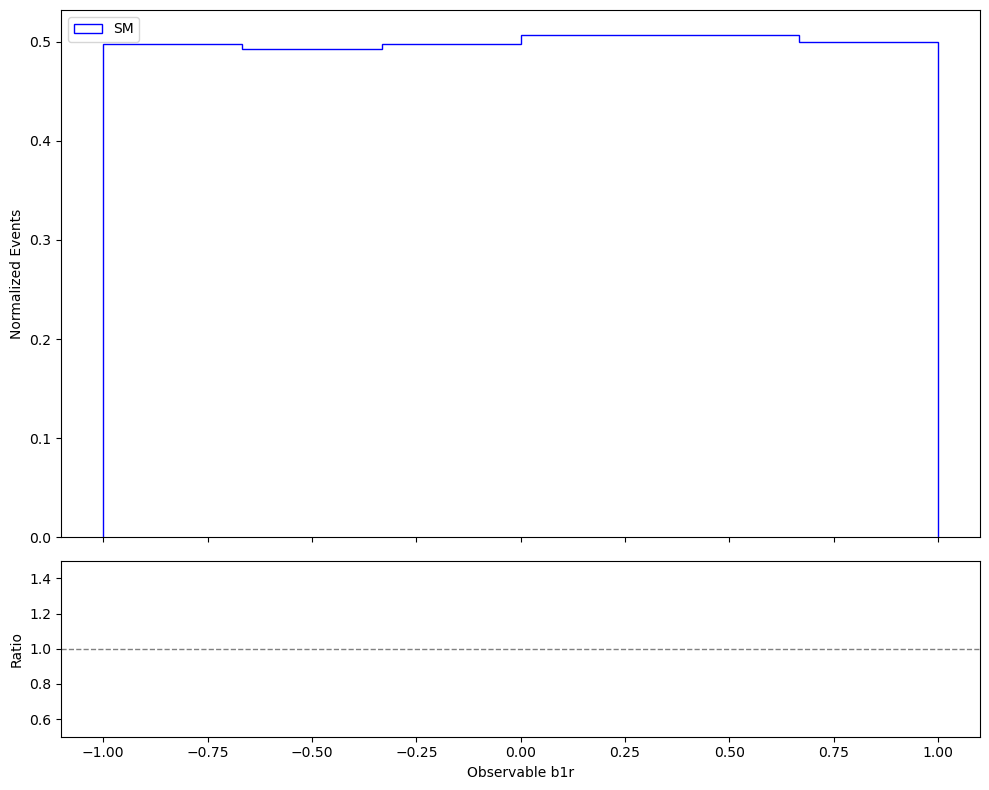

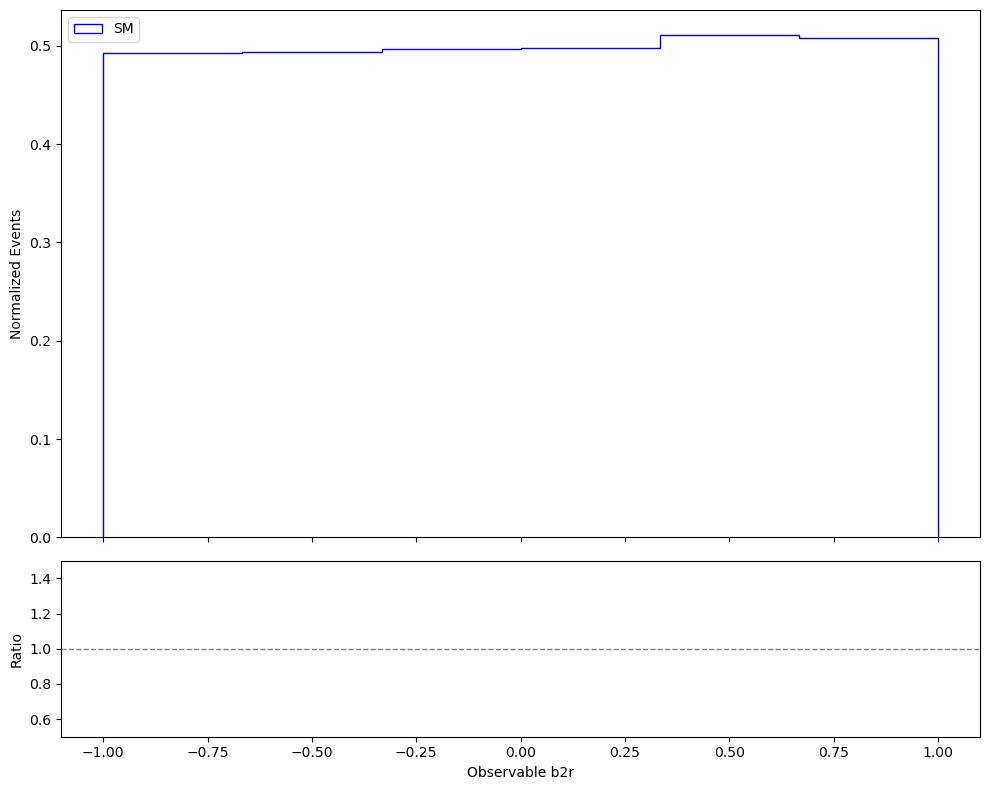

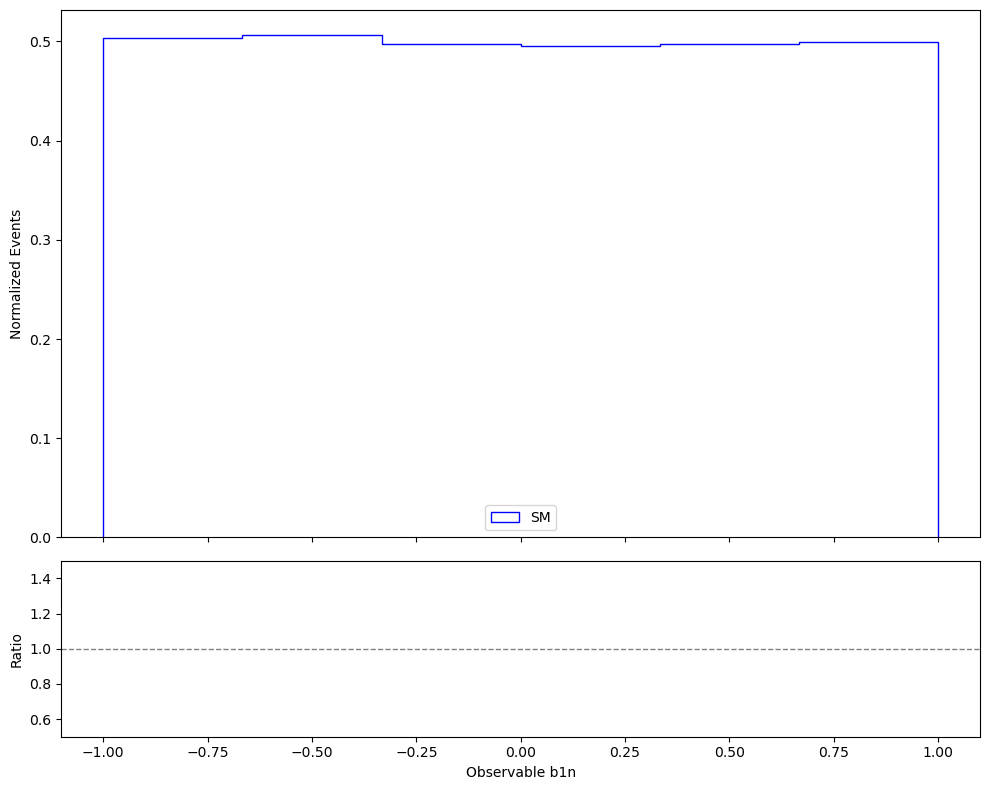

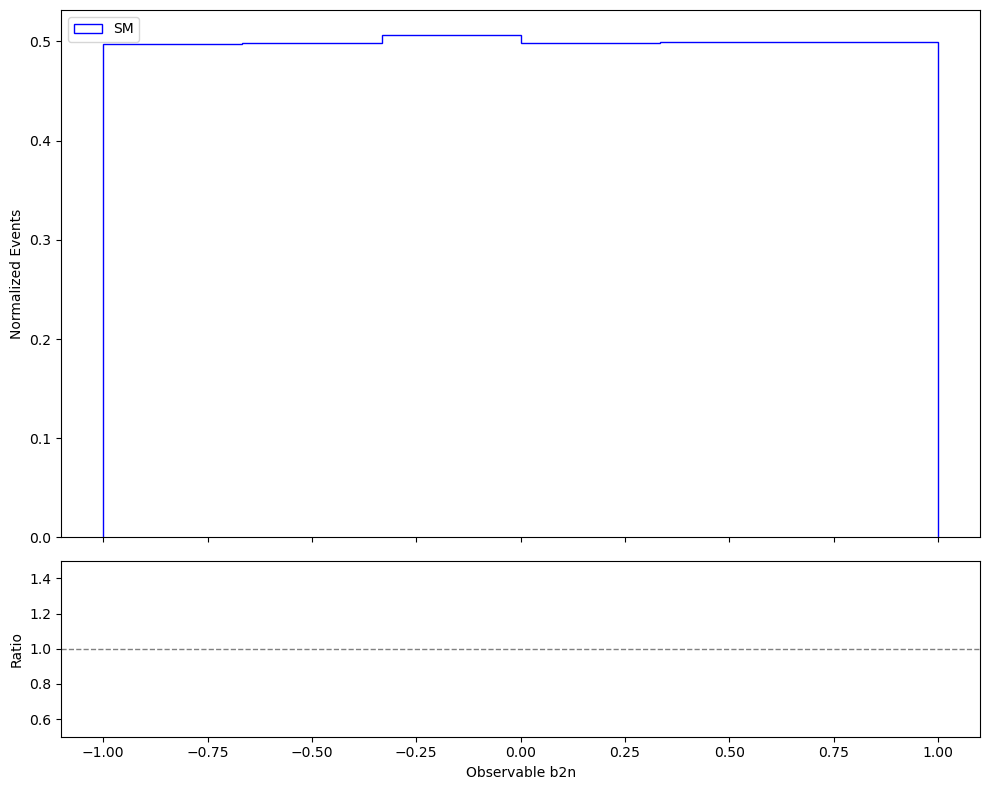

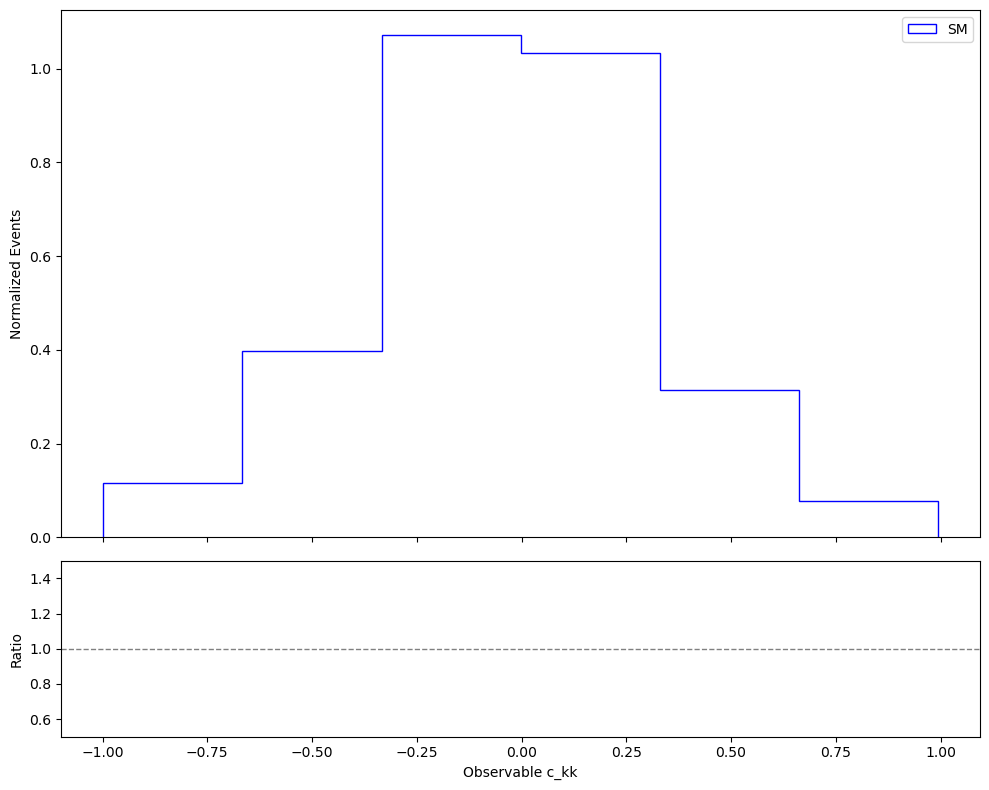

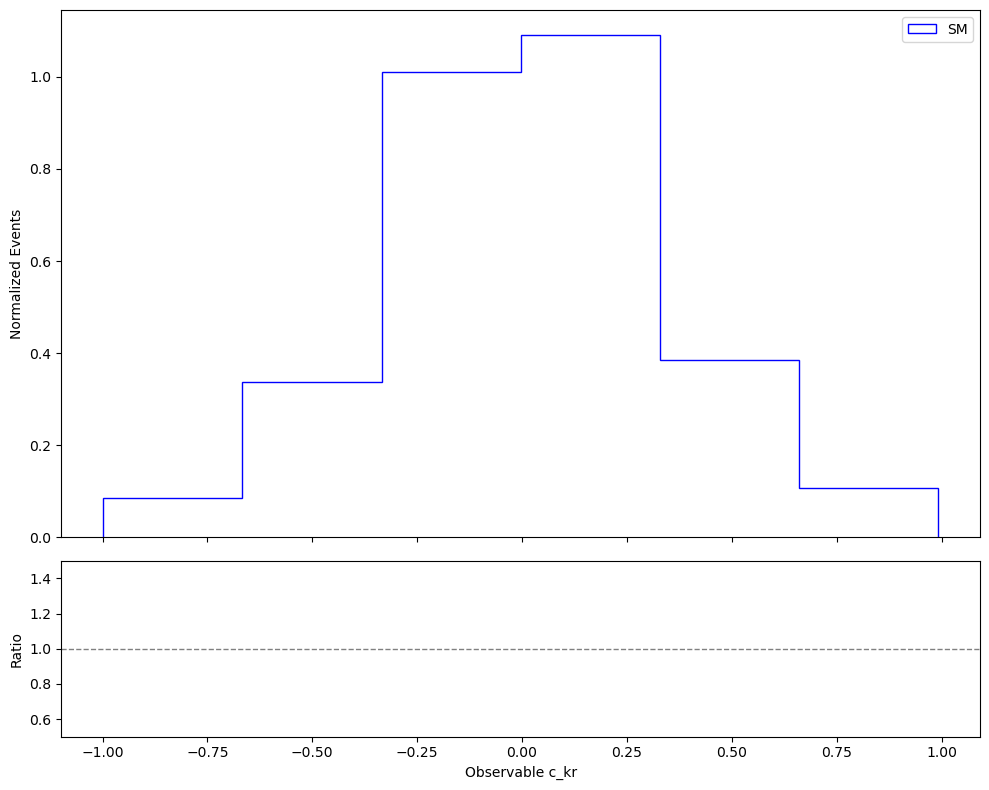

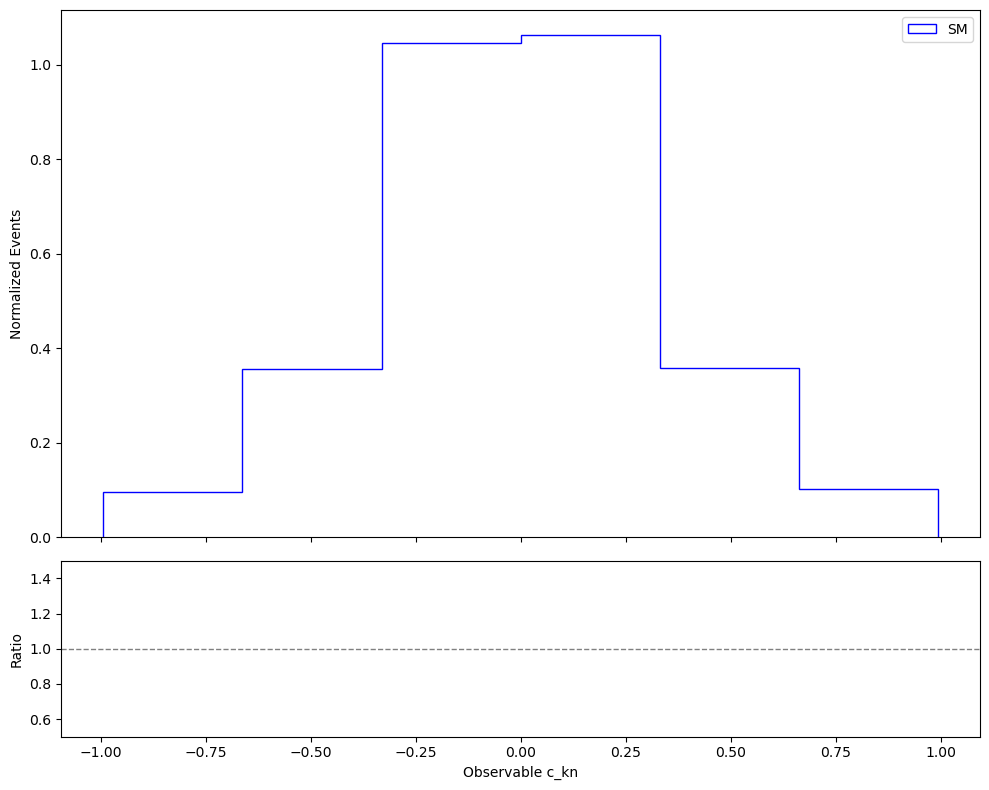

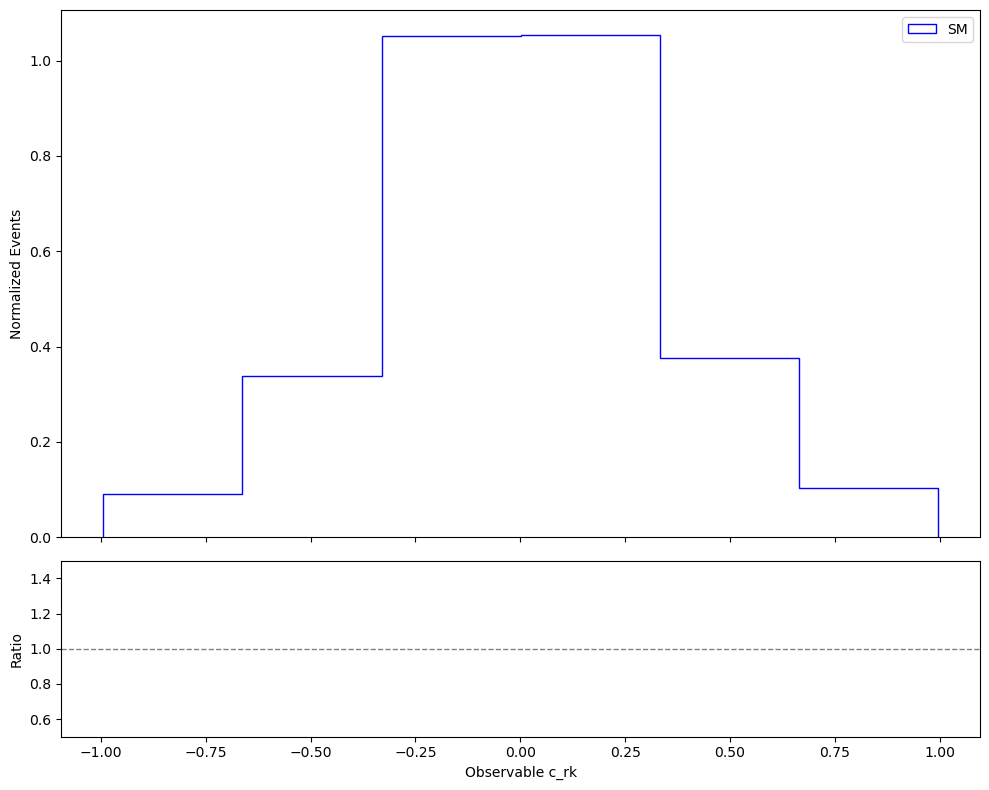

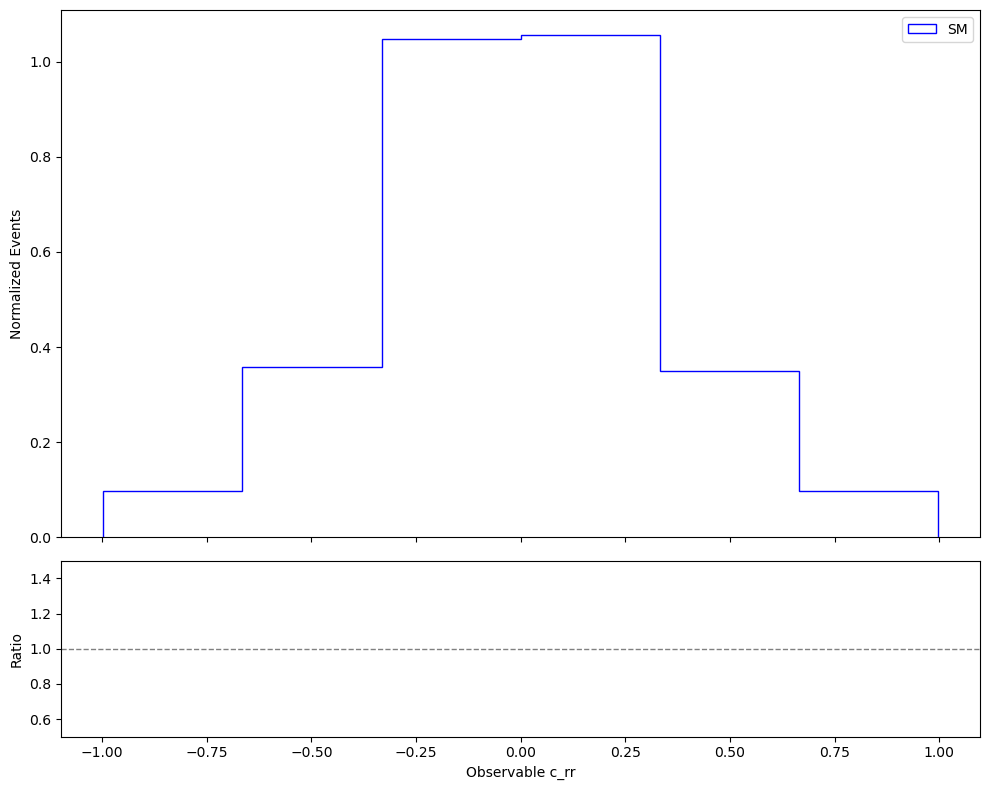

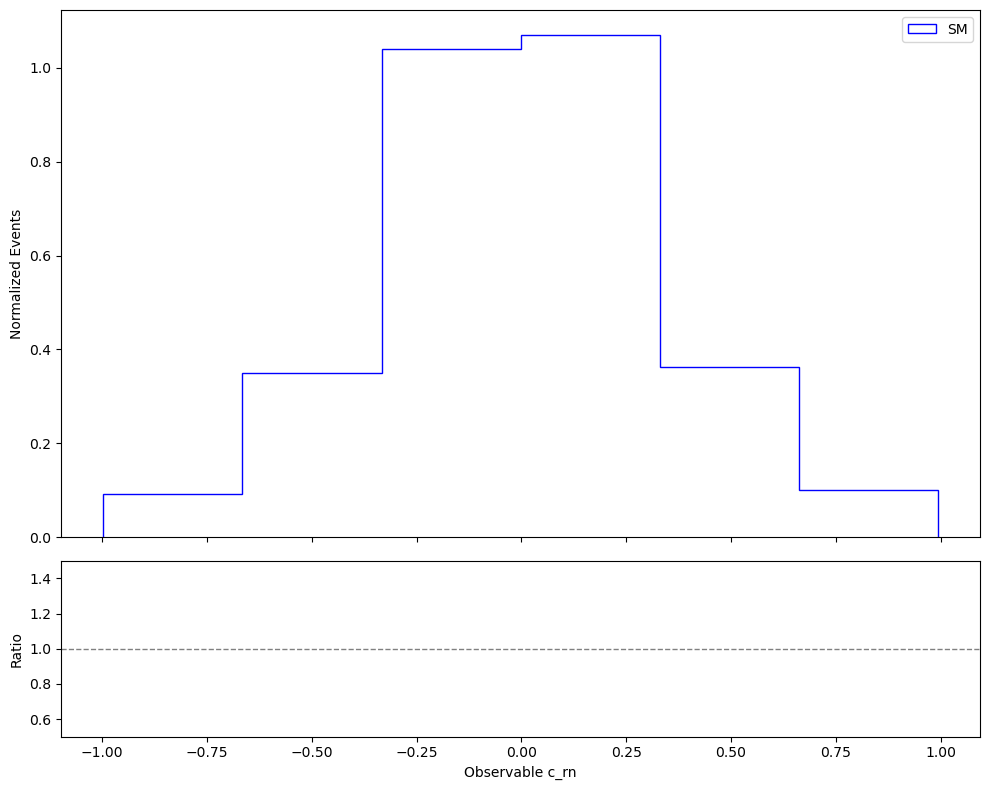

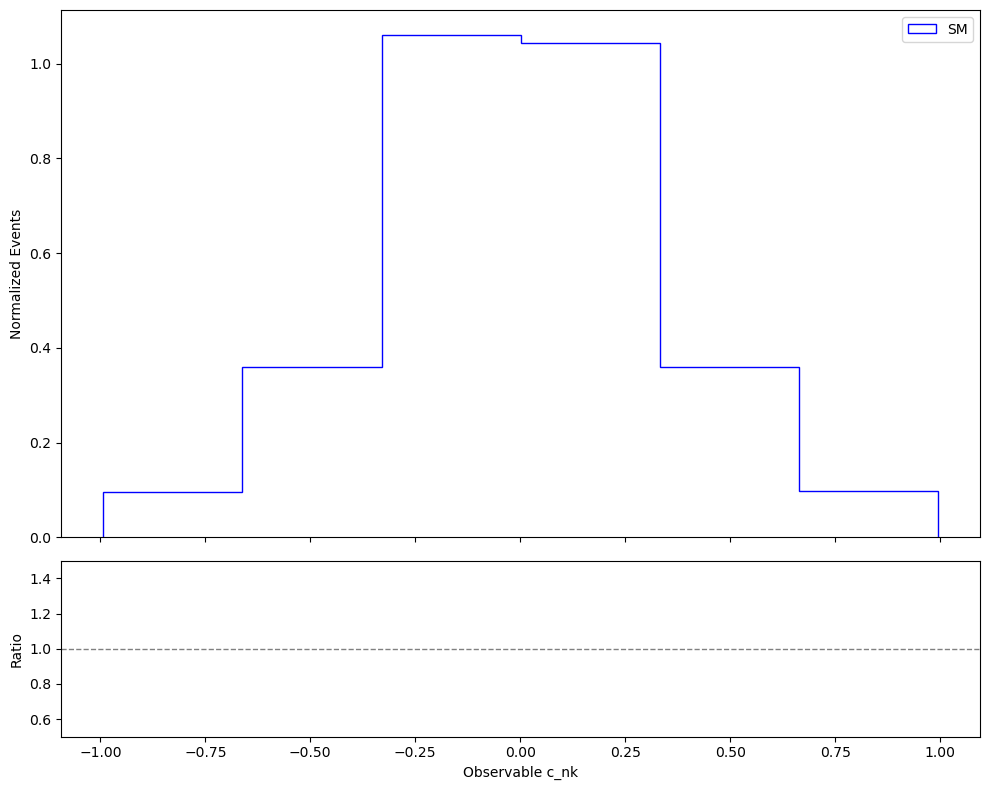

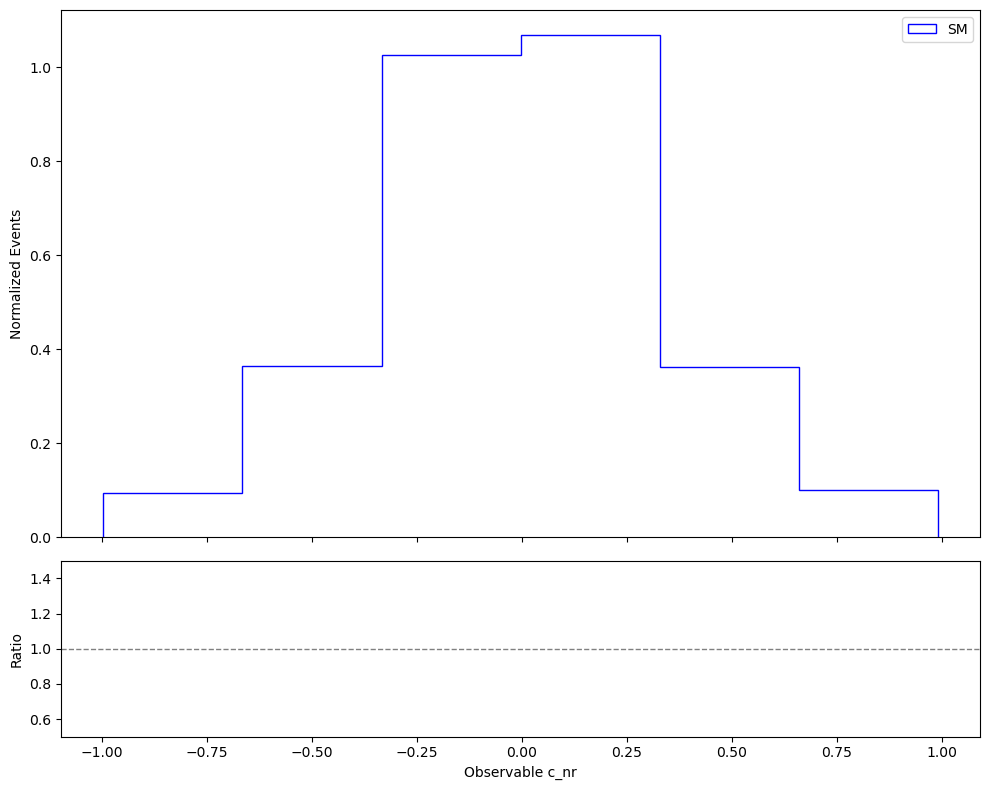

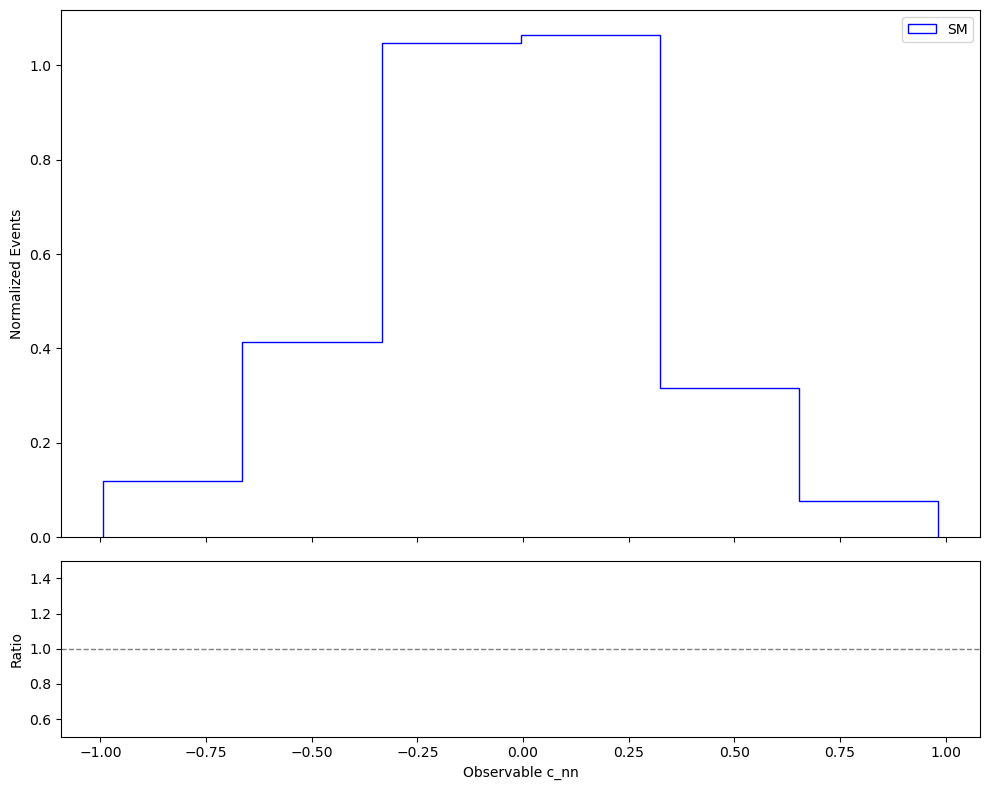

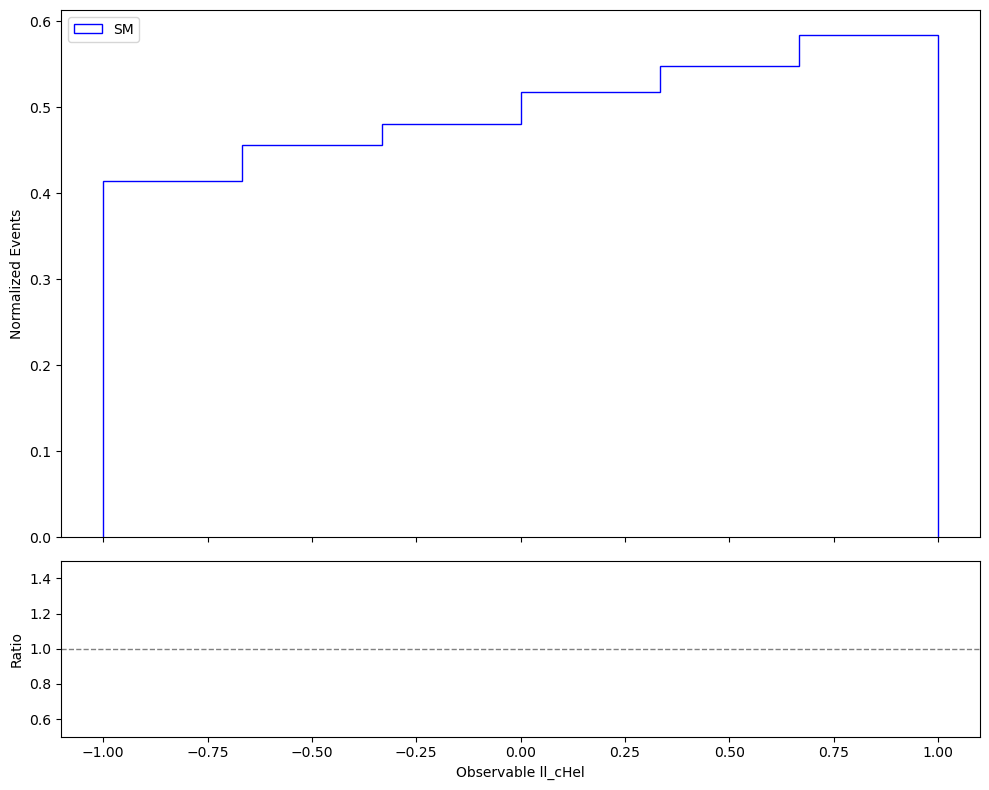

In [338]:
# Plotting example
observables = {
    'b1k': B1[:, 0], 'b2k': B2[:, 0], 'b1r': B1[:, 1], 'b2r': B2[:, 1], 'b1n': B1[:, 2], 'b2n': B2[:, 2],
    'c_kk': C[:, 0, 0], 'c_kr': C[:, 0, 1], 'c_kn': C[:, 0, 2],
    'c_rk': C[:, 1, 0], 'c_rr': C[:, 1, 1], 'c_rn': C[:, 1, 2],
    'c_nk': C[:, 2, 0], 'c_nr': C[:, 2, 1], 'c_nn': C[:, 2, 2],
    'll_cHel': ll_cHel
}

def plot_observables(obs, weights, xlabel):
    fig, (ax, ax_ratio) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'purple']
    reference_label = list(weights.keys())[0]
    reference_weight = weights[reference_label]
    reference_counts = None
    bin_centers = None
    for i, (label, weight) in enumerate(weights.items()):
        counts, bins, _ = ax.hist(
            obs,
            bins=6,
            weights=weight,
            label=label,
            color=colors[i % len(colors)],
            histtype='step',
            density=True
        )
        if i == 0:
            reference_counts = counts
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
        else:
            ratio = np.divide(counts, reference_counts, out=np.zeros_like(counts), where=reference_counts != 0)
            ax_ratio.plot(bin_centers, ratio, label=f"{label}/{reference_label}", marker='o', linestyle='none', color=colors[i % len(colors)])
    ax_ratio.set_ylabel('Ratio')
    ax_ratio.set_ylim(0.5, 1.5)
    ax_ratio.axhline(1, color='gray', linestyle='--', linewidth=1)
    ax.set_ylabel("Normalized Events")
    ax.legend(loc='best')
    ax_ratio.set_xlabel(xlabel)
    plt.tight_layout()
    plt.show()

# Plot examples
weights = {'SM': a[dilepton_event_mask]}
for label in observables:
    plot_observables(observables[label], weights, xlabel=f"Observable {label}")


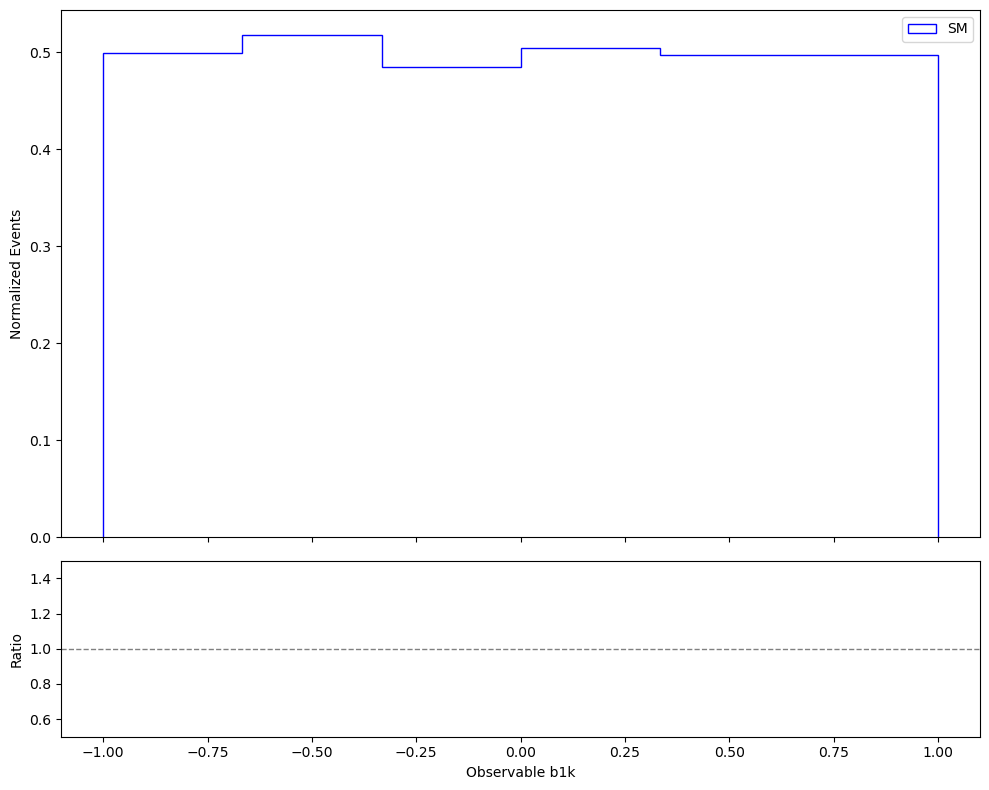

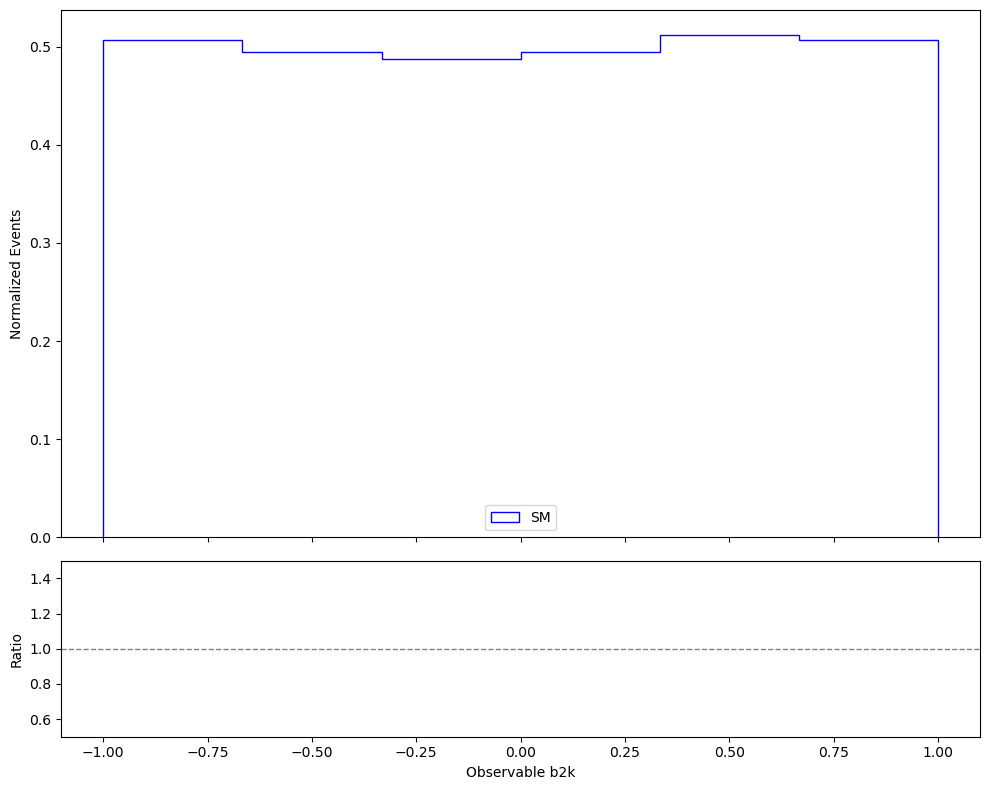

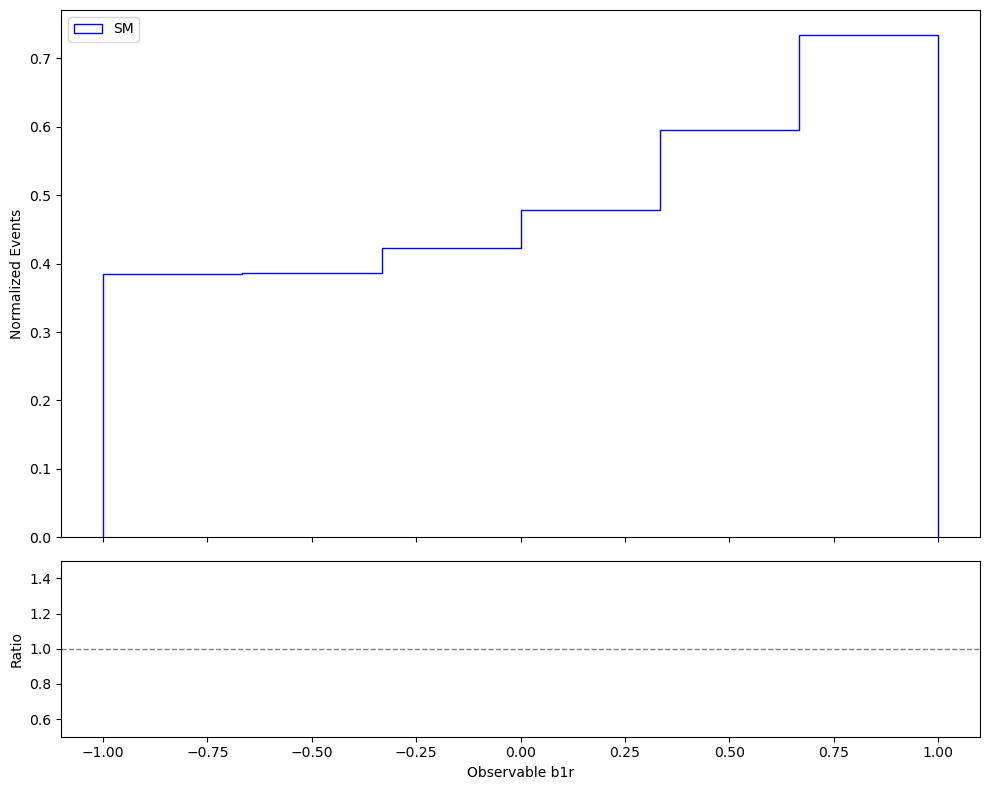

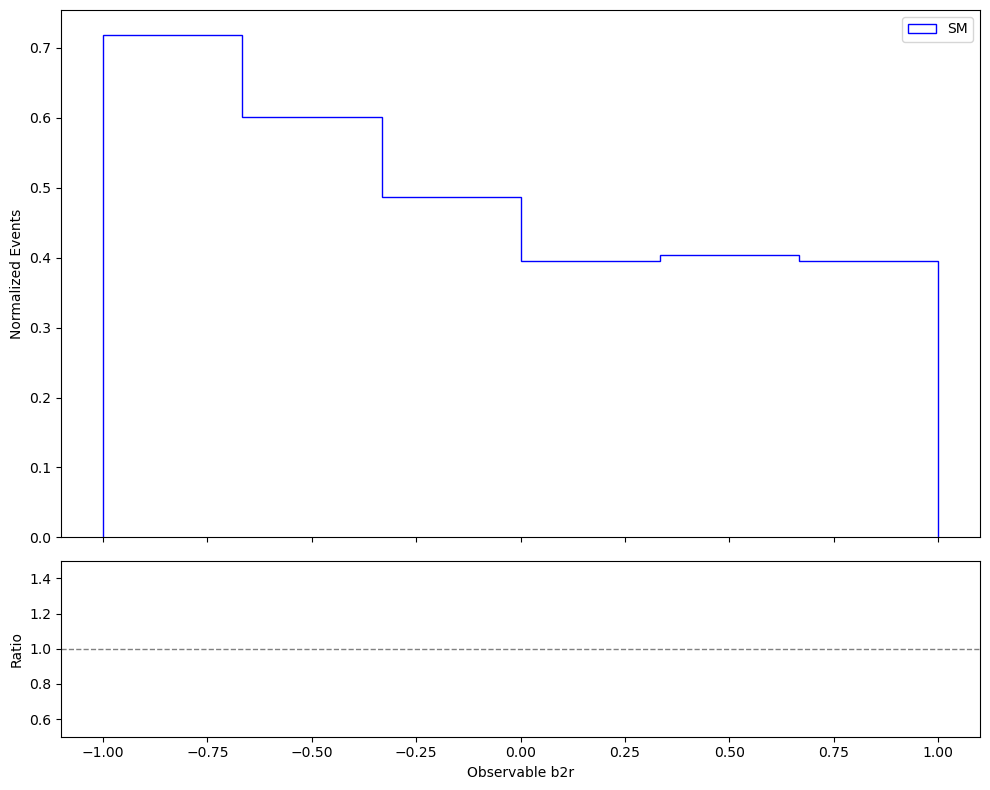

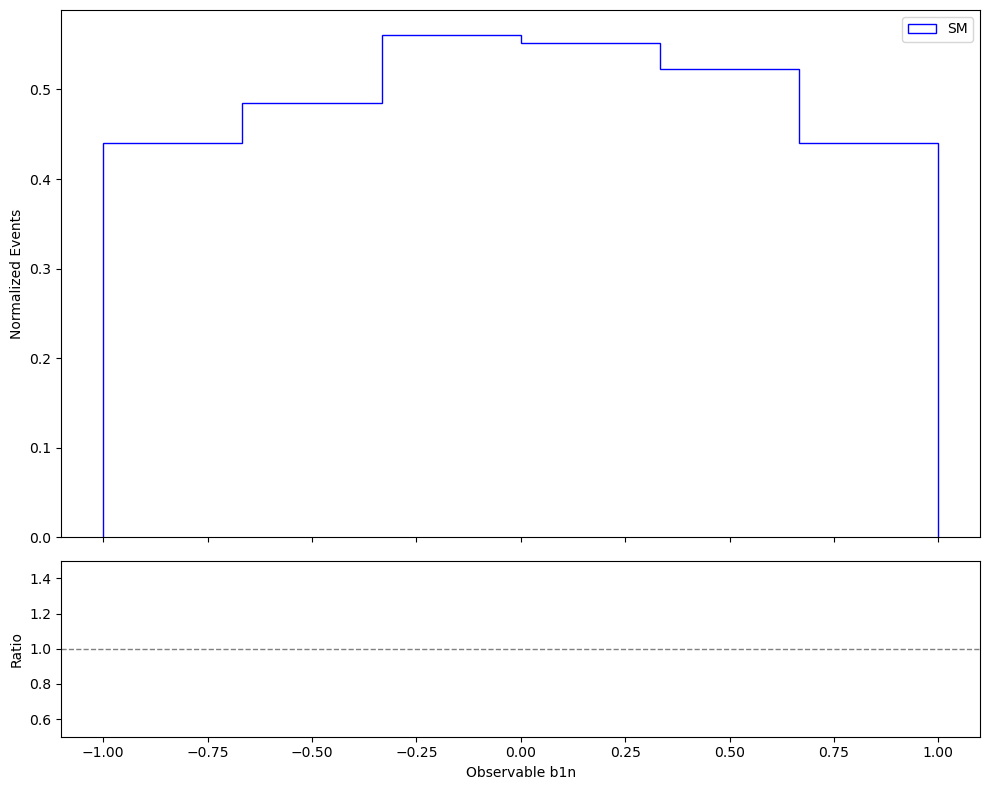

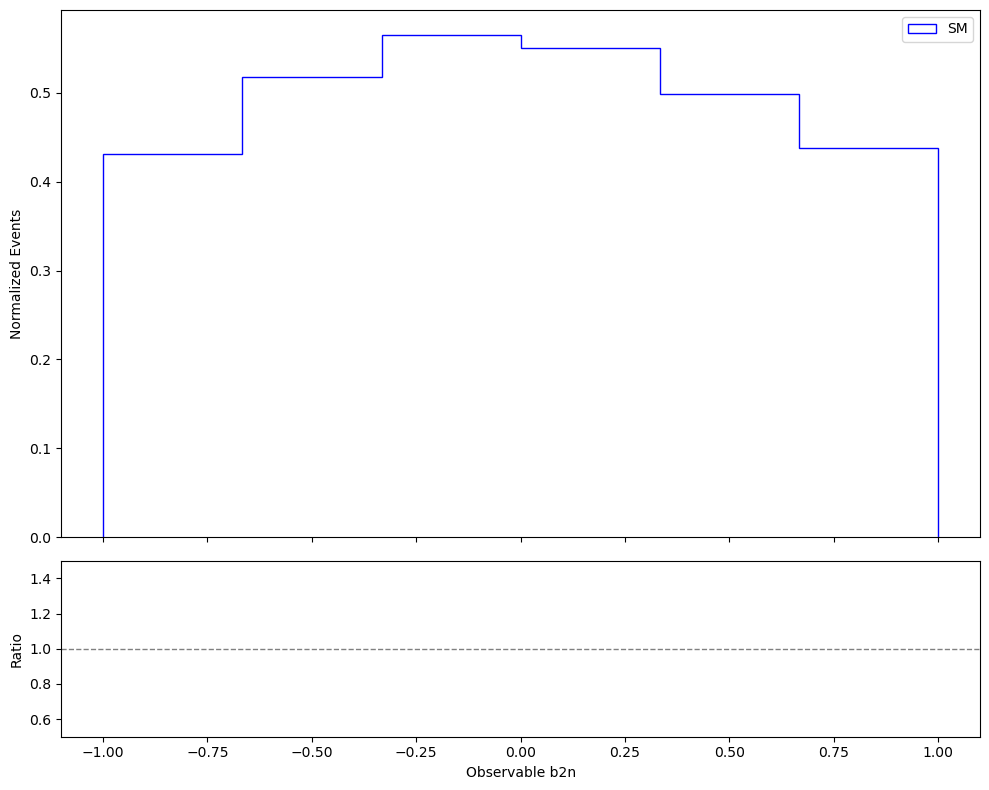

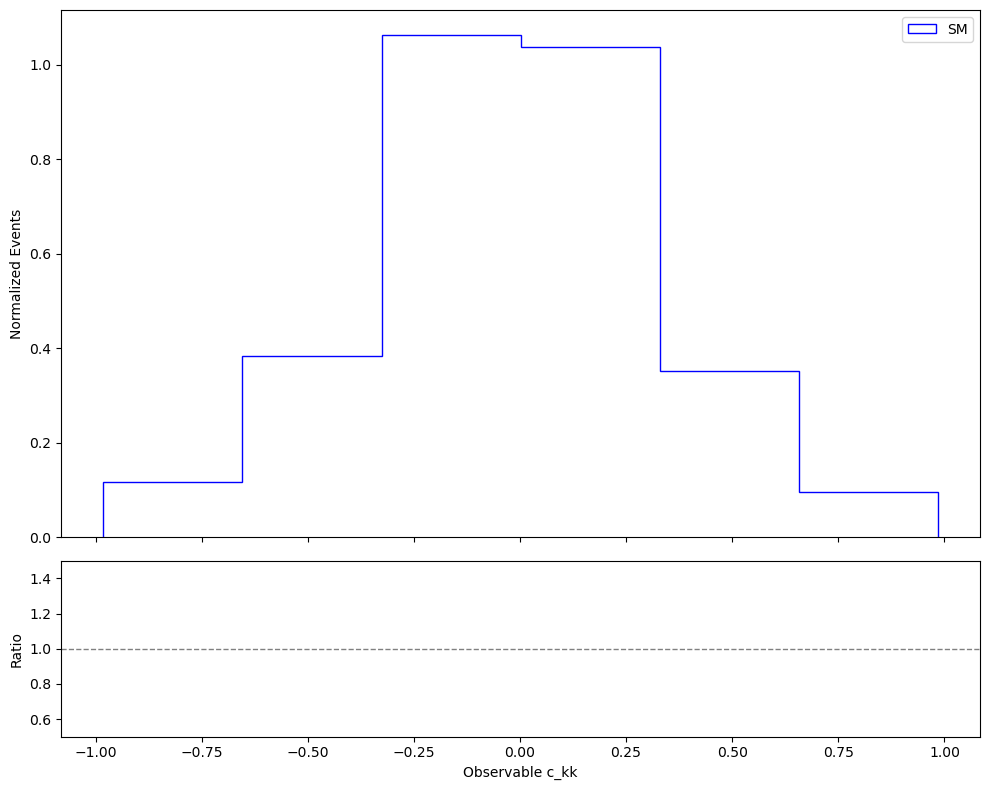

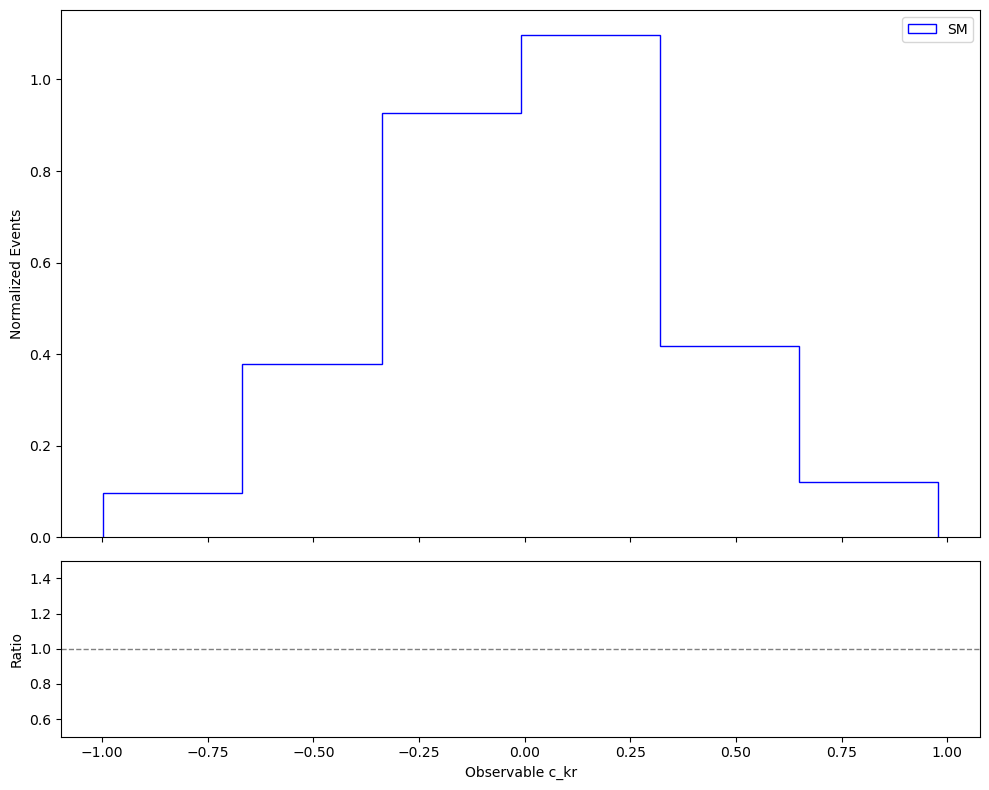

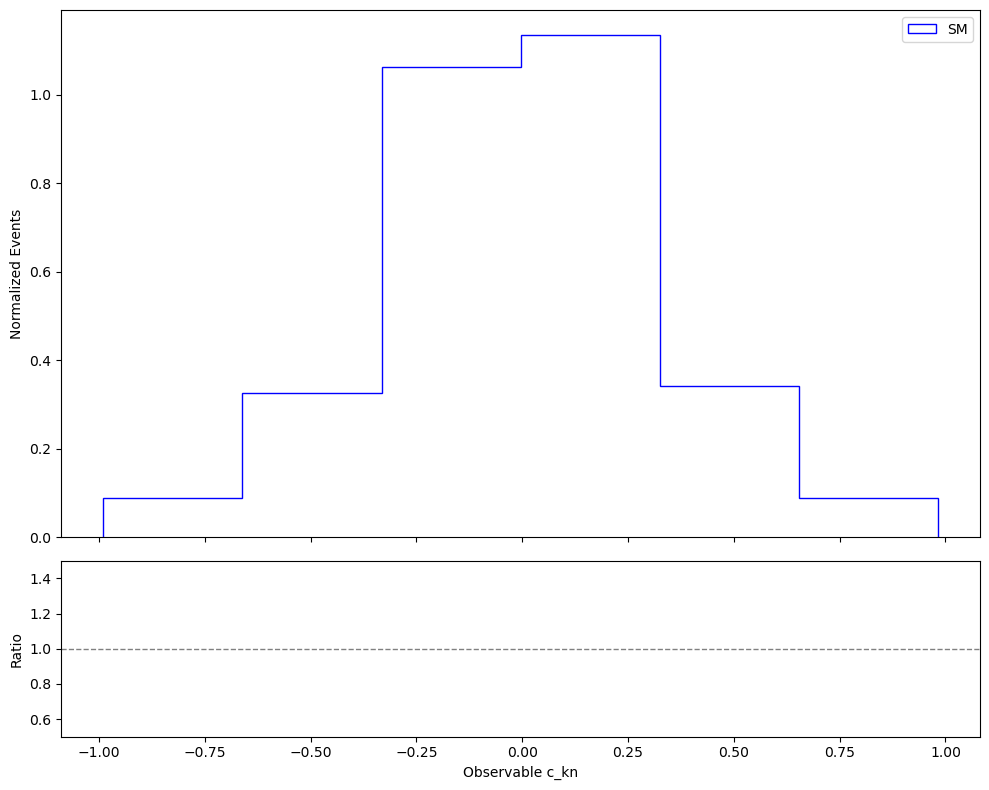

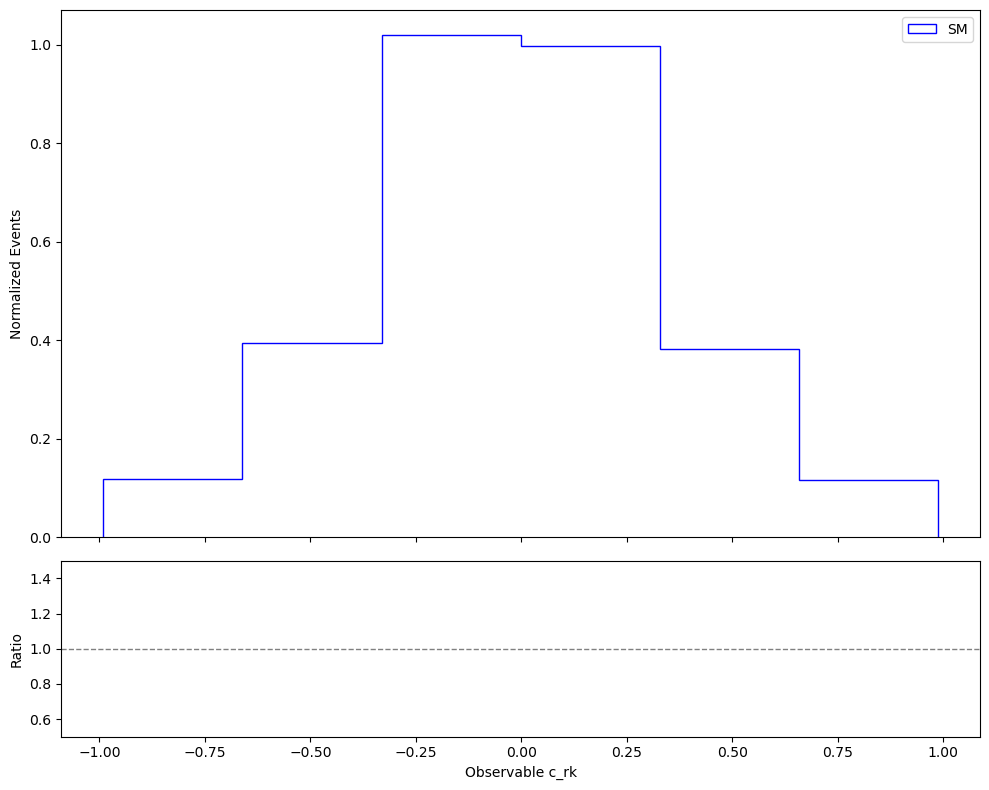

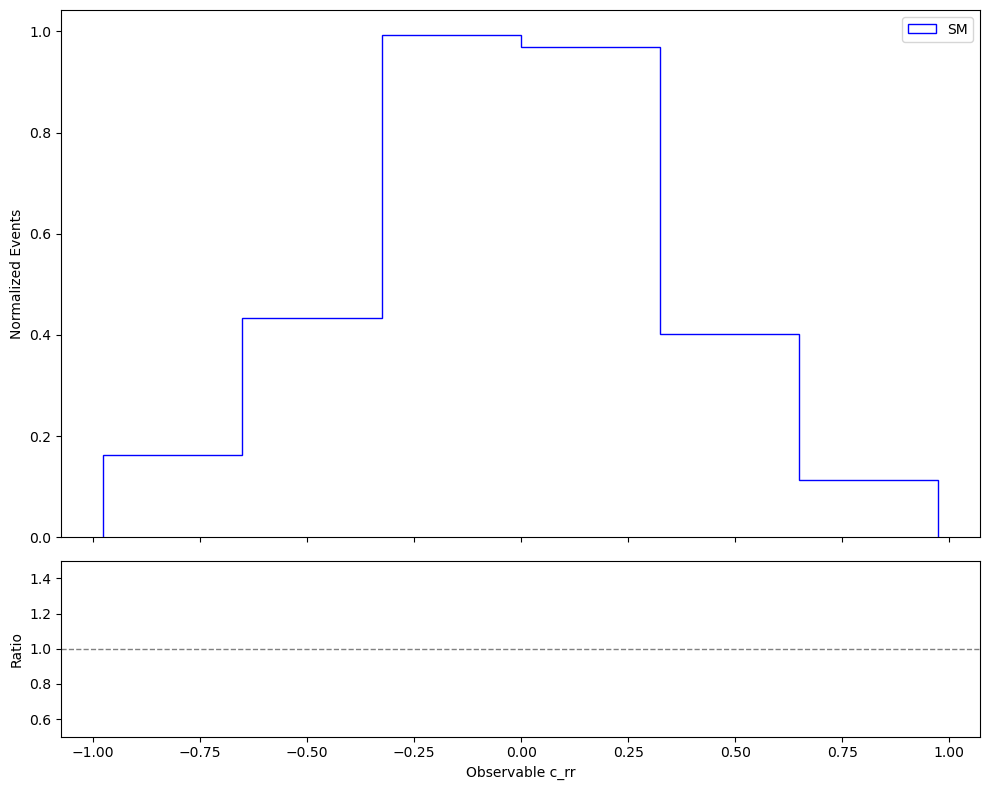

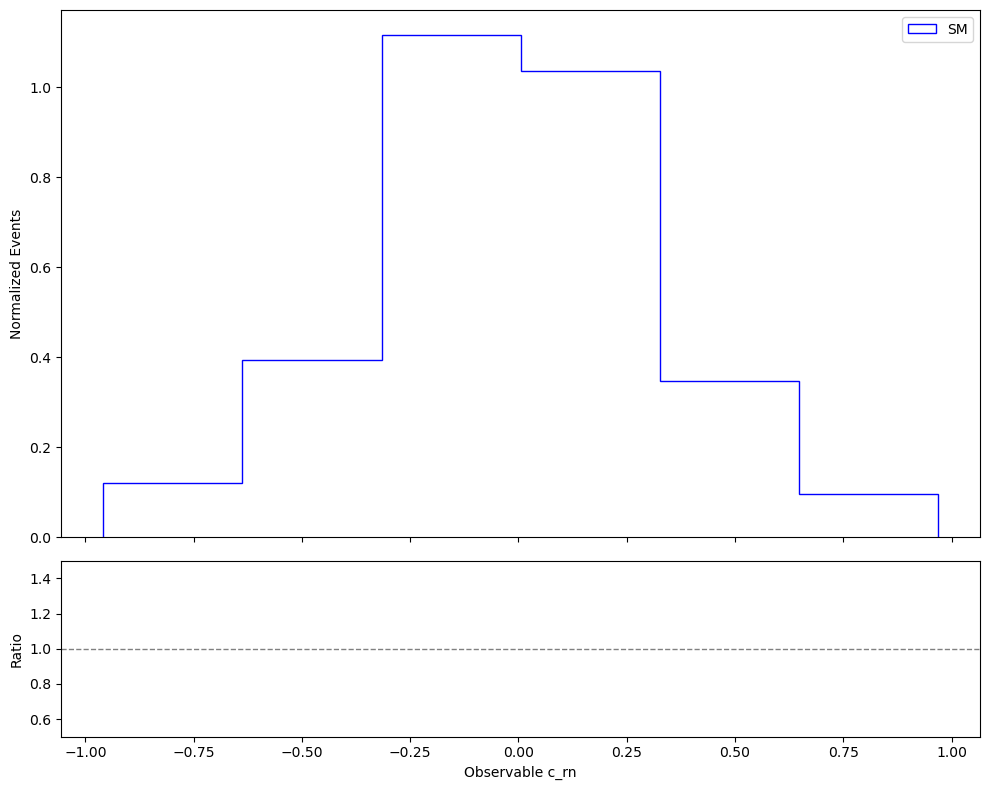

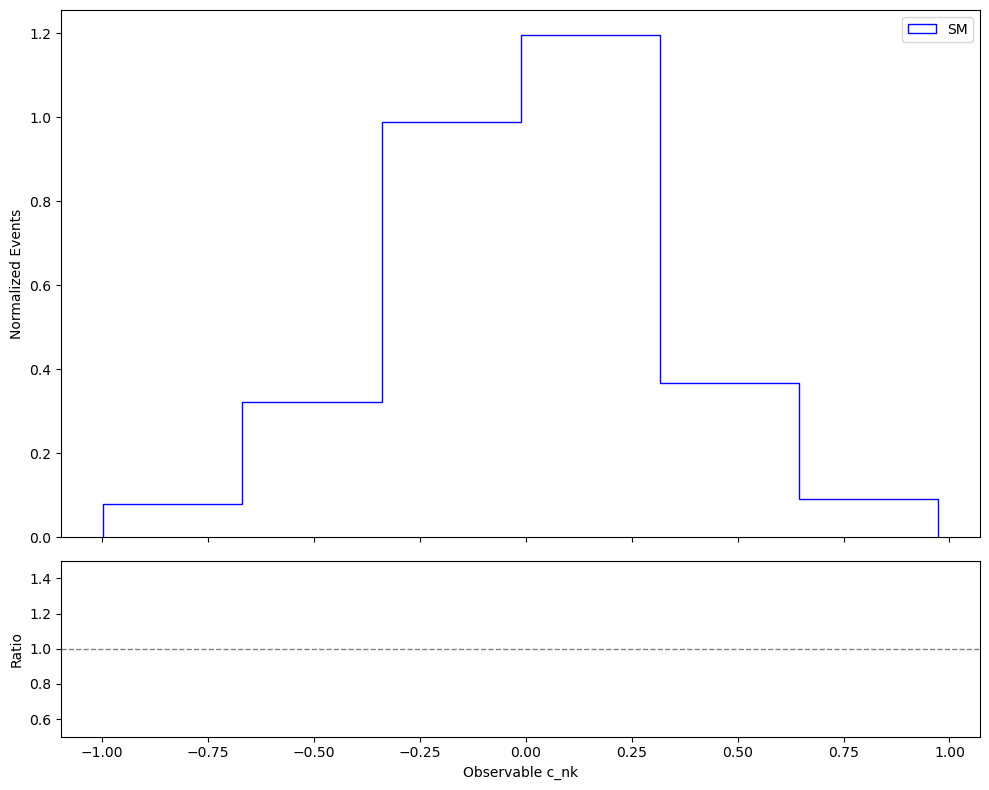

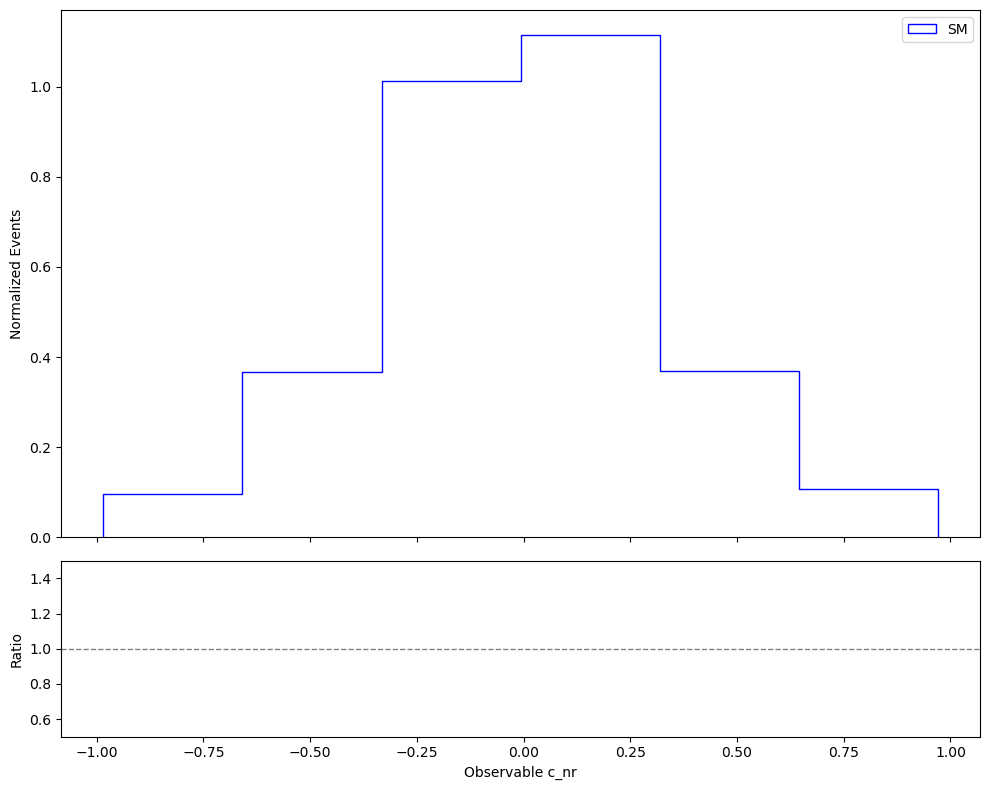

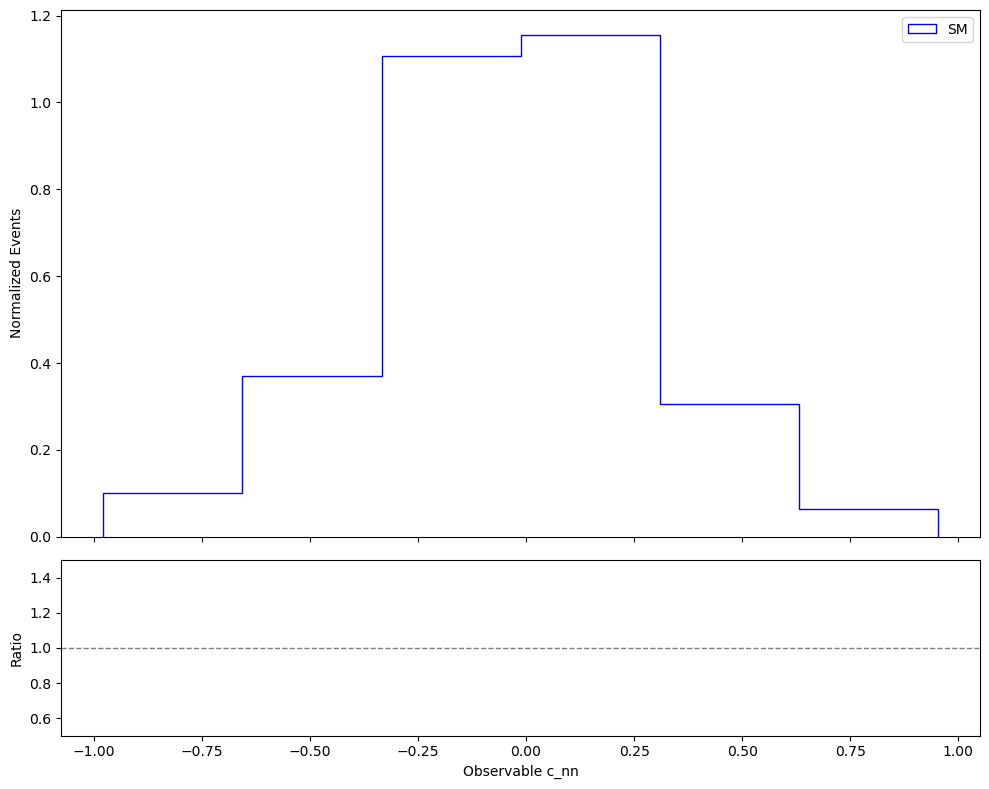

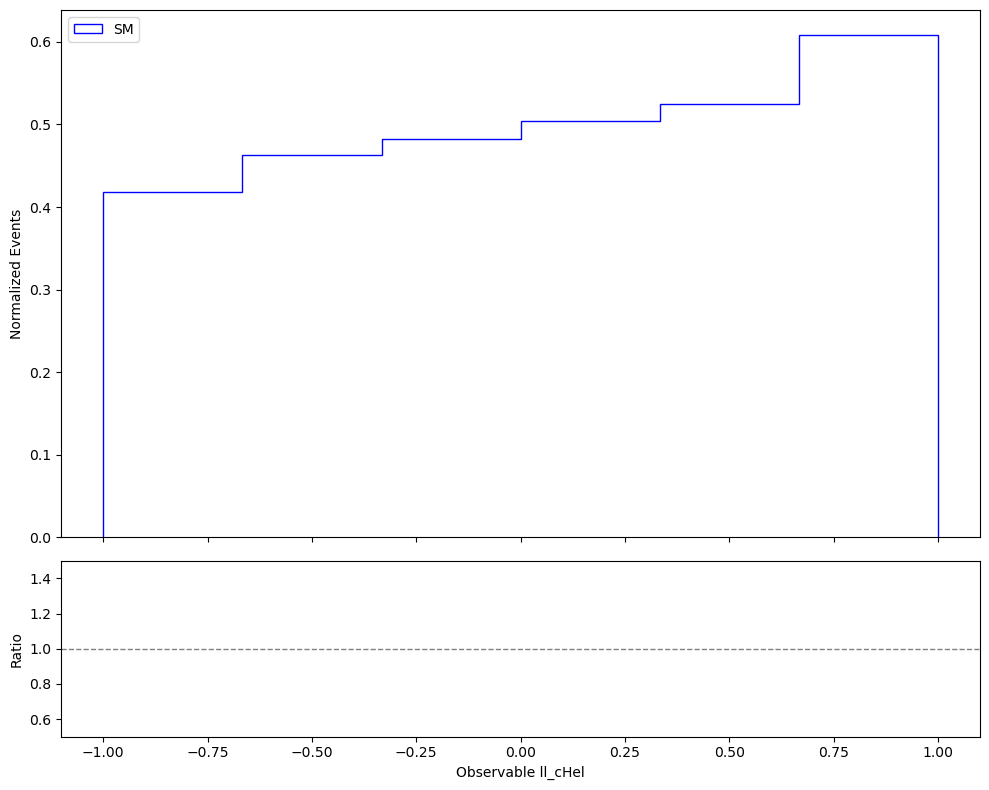

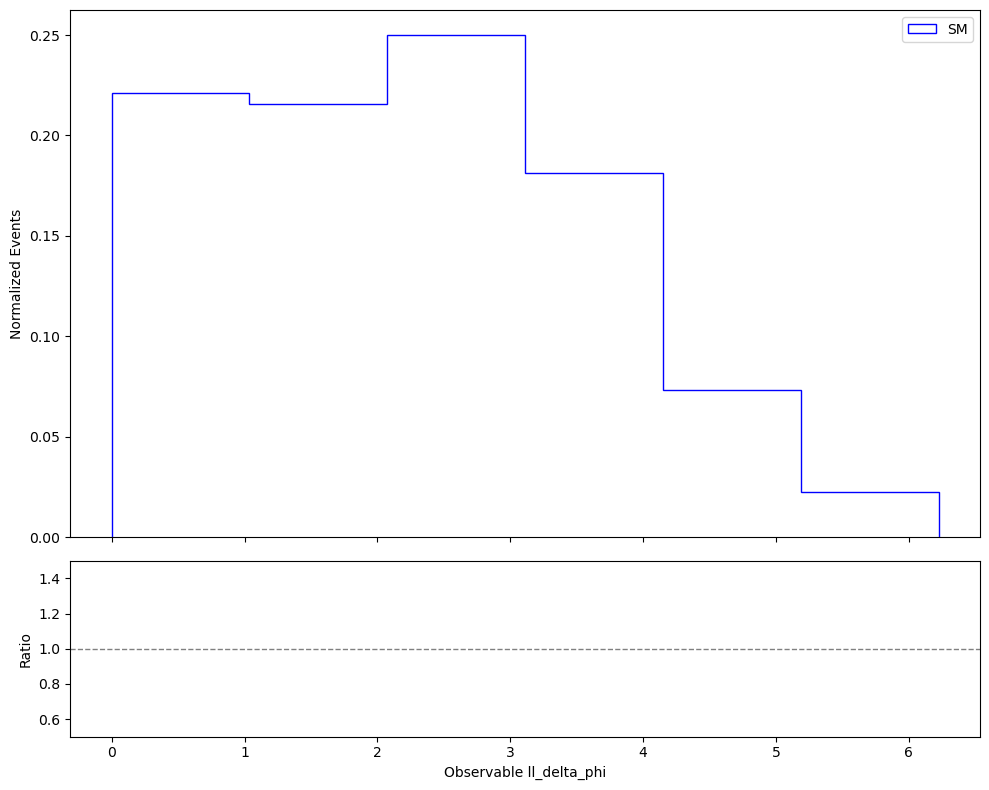

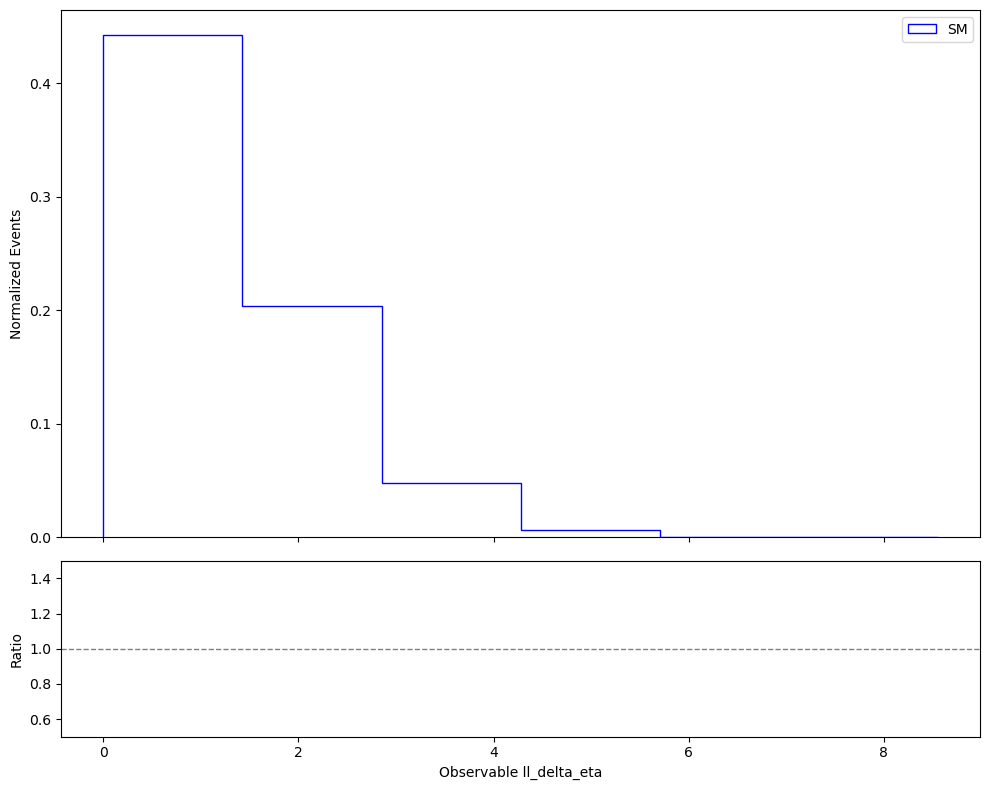

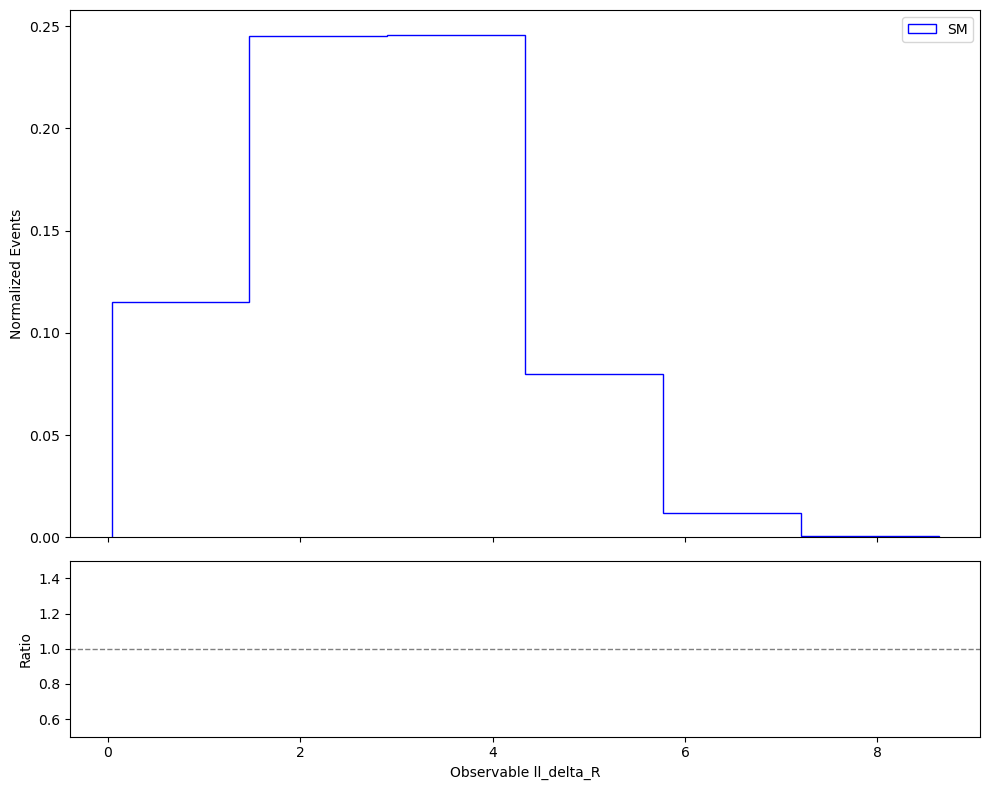

In [85]:
# Example usage

observables_labels = ['b1k', 'b2k', 'b1r', 'b2r', 'b1n', 'b2n', 'c_kk', 'c_kr', 'c_kn','c_rk','c_rr','c_rn','c_nk','c_nr','c_nn','ll_cHel','ll_delta_phi','ll_delta_eta','ll_delta_R']
observables_titles = [
    'Spin Correlation: b1k', 'Spin Correlation: b2k', 'Spin Correlation: b1r',
    'Spin Correlation: b2r', 'Spin Correlation: b1n', 'Spin Correlation: b2n',
    'Spin Correlation: ckk', 'Spin Correlation: ckr', 'Spin Correlation: ckn'
]

weights = {
    'SM': a1
    #'ctGRe': weight_ctGRe1,
    #'cQu8': weight_cQu8,
    #'ctgRe_cQu8': weight_ctgRe_cQu8
}

# Plot each observable
for i, label in enumerate(observables_labels):
    plot_observables(
        gen_spincorr_vars[i],  # Observable data
        weights,               # Weight dictionary
        xlabel=f"Observable {label}"
    )


In [24]:

observables_labels = ['mttbar', 'lepton_pt', 'antilepton_pt', 'lepton_eta', 'antilepton_eta']

# Create a dictionary of observables
observables = {
    "mttbar": mttbar[vec_mask],  # Example: Sum of top and antitop masses
    "lepton_pt": lep_pt[vec_mask],
    "antilepton_pt": alep_pt[vec_mask],
    "lepton_eta": lep_eta[vec_mask],
    "antilepton_eta": alep_eta[vec_mask]
}

# Plot each observable
for label in observables_labels:
    plot_observables(
        observables[label],  # Observable data accessed by key (label)
        weights,             # Weight dictionary
        xlabel=f"Observable {label}"
    )


NameError: name 'mttbar' is not defined

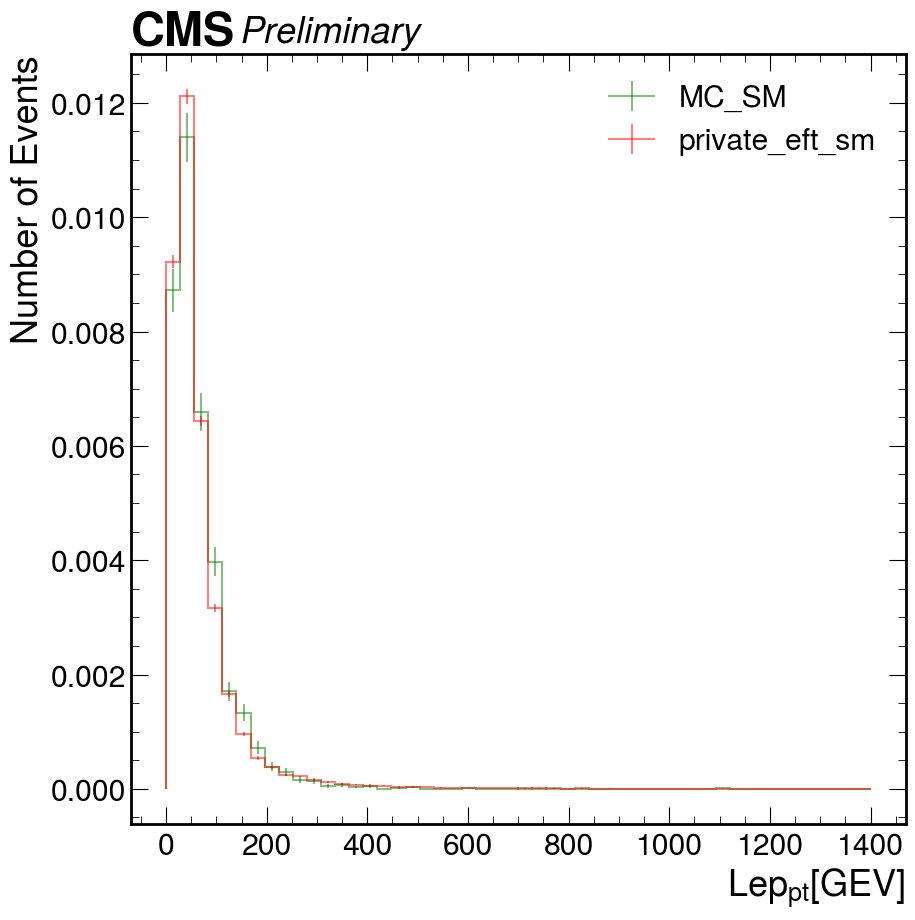

In [142]:
def plot_kinematics(lepton_eft,lepton_sm,sbin,ebin,bin,xlabel):
    # Define the lep_pt axis with range 0 to 400 and 50 bins
    lep_axis = hist.axis.Regular(bin, sbin, ebin,name="lep_ax", underflow=True, overflow=True)

    # Create histograms
    h_WC0 = hist.Hist(lep_axis)
    h_SM = hist.Hist(lep_axis)

    # Fill the histograms with flattened lep_pt and corresponding weights
    h_WC0.fill(lep_ax=ak.flatten(lepton_sm), weight=weight_sm[vec_mask_sm])
    h_SM.fill(lep_ax=ak.flatten(lepton_eft), weight=weight_WC0[vec_mask])

    # Extract bin content and edges
    bin_content0, bin_edges0 = h_WC0.to_numpy()
    bin_content1, bin_edges1 = h_SM.to_numpy()

    # Calculate statistical errors
    errors0 = np.sqrt(bin_content0)
    errors1 = np.sqrt(bin_content1)

    # Load CMS style
    plt.style.use(hep.style.CMS)

    # Create the figure and axes
    fig, ax = plt.subplots()

    # Plot the histograms with error bars
    hep.histplot(bin_content0, bin_edges0, density=True, yerr=errors0, color='green', label='MC_SM', ax=ax,histtype='step', alpha=0.5)
    hep.histplot(bin_content1, bin_edges1, density=True, yerr=errors1, color='red', label='private_eft_sm', ax=ax,histtype='step', alpha=0.5)

    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Number of Events')
    #ax.set_title('Comparison of Histograms')
    ax.legend()

    # Add CMS Preliminary header
    hep.cms.text("Preliminary", ax=ax)
    
    # Set x-axis range
    #ax.set_xlim(0, 400)
    #ax.set_yscale('log')
    # Show the plot
    plt.show()
plot_kinematics(lep_pt[vec_mask],lep_pt_sm[vec_mask_sm],0,1400,50,'$Lep_{pt} [GEV]$')

In [1]:
# Define the lep_pt axis with range 0 to 400 and 50 bins
lep_pt_axis = hist.axis.Regular(40, 0, 400, name="lep_pt_ax", label="lep_pt", underflow=True, overflow=True)

# Create histograms
h_SM = hist.Hist(lep_pt_axis)
h_ctgRe1 = hist.Hist(lep_pt_axis)

# Fill the histograms with flattened lep_pt and corresponding weights
h_SM.fill(lep_pt_ax=ak.flatten(trailing_lep_pt), weight=weight_sm[vec_mask])
h_ctgRe1.fill(lep_pt_ax=ak.flatten(trailing_lep_pt), weight=weight_ctGRe1[vec_mask])

# Extract bin content and edges
bin_content0, bin_edges0 = h_SM.to_numpy()
bin_content1, bin_edges1 = h_ctgRe1.to_numpy()

# Calculate statistical errors
errors0 = np.sqrt(bin_content0)
errors1 = np.sqrt(bin_content1)

# Load CMS style
plt.style.use(hep.style.CMS)

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the histograms with error bars
hep.histplot(bin_content0, bin_edges0, yerr=errors0, color='green', label='SM', ax=ax,histtype='step', alpha=0.5)
hep.histplot(bin_content1, bin_edges1, yerr=errors1, color='red', label='ctgRe=10', ax=ax,histtype='step', alpha=0.5)

# Add labels and title
ax.set_xlabel('$p_T^l(trailing)[GeV]$')
ax.set_ylabel('Number of Events')
#ax.set_title('Comparison of Histograms')
ax.legend()

# Add CMS Preliminary header
hep.cms.text("Preliminary", ax=ax)

# Set x-axis range
#ax.set_xlim(0, 400)
ax.set_yscale('log')
# Show the plot
plt.show()


NameError: name 'hist' is not defined

In [19]:
################################################################################################################################################################
# Define the CMS style plot function with support for multiple sets of weights

def plot_cms_style(data, weights_list, labels, xlabel, ylabel, title):
    plt.figure(figsize=(8, 6))
    
    # Plot histograms with weights
    for weights, label in zip(weights_list, labels):
        plt.hist(data, bins=6, range=(-1, 1), histtype='step', linewidth=2, density=False, weights=weights, label=label)
    
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(title, fontsize=16, loc='right')
    
    # CMS style text
    plt.text(0, 1.05, 'CMS', verticalalignment='top', horizontalalignment='left', transform=plt.gca().transAxes, fontsize=14, weight='bold')
    
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
################################################################################################################################################################
def plot_cms_style_norm(data, weights_list, labels, xlabel, ylabel, title):
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.12)
    
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    
    # Prepare data for the top plot
    bin_centers = np.linspace(-1, 1, 6)
    hist_data = []

    for weights, label in zip(weights_list, labels):
        counts, bins, _ = ax1.hist(data, bins=6, range=(-1, 1), histtype='step', linewidth=2, density=True, weights=weights, label=label)
        hist_data.append((counts, bins, label))
    
    
    ax1.set_ylabel(ylabel, fontsize=16)
    ax1.set_title(title, fontsize=16, loc='right')
    ax1.text(0, 1.05, 'CMS Simulation Preliminary', verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, fontsize=14, weight='bold')
    ax1.grid(True)
    ax1.legend()
    
    # Prepare data for the bottom plot, only for 'QCD+EFT²' weights
    # Calculate and plot the ratio of QCD+Linear and QCD+EFT² to QCD
    ax2 = plt.subplot(2, 1, 2)  # Create the second subplot (bottom)

    # Extract histogram data for QCD
    qcd_counts = hist_data[2][0]  # Assuming QCD is the third in weights_list
    bins = hist_data[2][1]
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Plot ratios for QCD+Linear and QCD+EFT²
    for counts, bins, label in hist_data[:2]:  # Include 'QCD+Linear' and 'QCD+EFT²' weights
        ratio = counts / qcd_counts
        ax2.plot(bin_centers, ratio, 'o-')

    ax2.set_xlabel(xlabel, fontsize=16)
    ax2.set_ylabel('EFT/SM', fontsize=16)
    #ax2.set_title('EFT/SM', fontsize=16)
    ax2.set_ylim(0.75, 1.25)
    ax2.grid(True)
    ax2.legend()
    plt.tight_layout()

    plt.show()

    fig.savefig(f'validation_plots/{title}_vs_{xlabel}.pdf')

################################################################################################################################################################

def plot_ef_to_sm_ratio(data, weights_list, labels, xlabel, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Prepare data for the plot
    hist_data = []
    for weights, label in zip(weights_list, labels):
        counts, bins = np.histogram(data, bins=6, range=(-1, 1), density=True, weights=weights)
        hist_data.append((counts, bins, label))
    
    # Extract histogram data for SM
    sm_counts = hist_data[0][0]  # Assuming SM is the first in weights_list
    bins = hist_data[0][1]
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Plot ratios for EFT weights
    for counts, _, label in hist_data[1:]:  # Loop over all EFT weights (skipping the first which is SM)
        ratio = counts / sm_counts
        ax.plot(bin_centers, ratio, 'o-', label=label)

    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel('EFT/SM', fontsize=16)
    ax.set_title(title, fontsize=16, loc='right')
    ax.set_ylim(0.75, 1.25)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()

    plt.show()
################################################################################################################################################################    
# Example weights (assuming they are defined elsewhere)
#weights_nominal = np.ones_like(b1k)  # Example weights, should be defined according to your actual data
weights_ctGRe1 = weight_ctGRe1[vec_mask] 
weights_ctGRe2 = weight_ctGRe2[vec_mask]
weights_ctGIm1 = weight_ctGIm1[vec_mask]  
weights_ctGIm2 = weight_ctGIm2[vec_mask]
weights_cQj18 =  weight_cQj18[vec_mask] 
weights_cQj38 = weight_cQj38[vec_mask]
weights_cQj11 = weight_cQj11[vec_mask]  
weights_cQj31 = weight_cQj31[vec_mask]
weights_ctu8 = weight_ctu8[vec_mask] 
weights_ctd8 = weight_ctd8[vec_mask]
weights_ctj8 = weight_ctj8[vec_mask]  
weights_cQu8 = weight_cQu8[vec_mask]
weights_cQd8 = weight_cQd8[vec_mask]
weights_ctu1 = weight_ctu1[vec_mask]  
weights_ctd1 = weight_ctd1[vec_mask]
weights_ctj1 = weight_ctj1[vec_mask]
weights_cQu1 = weight_cQu1[vec_mask]  
weights_cQd1 = weight_cQd1[vec_mask]

weights_WC0=weight_WC0[vec_mask]
weights_sm= weight_sm[vec_mask]
#weights_list_R = [weights_ctGRe1,weights_ctGRe2,weights_sm]
#weights_list_I = [weights_ctGIm1,weights_ctGIm2,weights_sm]
weights_list=[weights_WC0,weights_sm]
labels =['SM','ctGRe=10']
#weight_all=[weights_sm,weights_ctGRe1, weights_ctGIm1, weights_cQj18, weights_cQj38, weights_cQj11, weights_cQj31, weights_ctu8, weights_ctd8, weights_ctj8, weights_cQu8, weights_cQd8, weights_ctu1, weights_ctd1, weights_ctj1, weights_cQu1, weights_cQd1]
#labels = ['SM+Linear','SM+EFT','SM']
#labels_all=['SM','ctGRe1', 'ctGIm1', 'cQj18', 'cQj38', 'cQj11', 'cQj31', 'ctu8', 'ctd8', 'ctj8', 'cQu8', 'cQd8', 'ctu1', 'ctd1', 'ctj1', 'cQu1', 'cQd1']

In [65]:
import numpy as np
ckk = gen_spincorr_vars[6]
plot_cms_style_norm(ckk, weights_list, labels, xlabel=r'$c_{kk}$', ylabel='Ratio', title='WC')

42647

/tmp/ipykernel_4806/1585550842.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_4806/1585550842.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


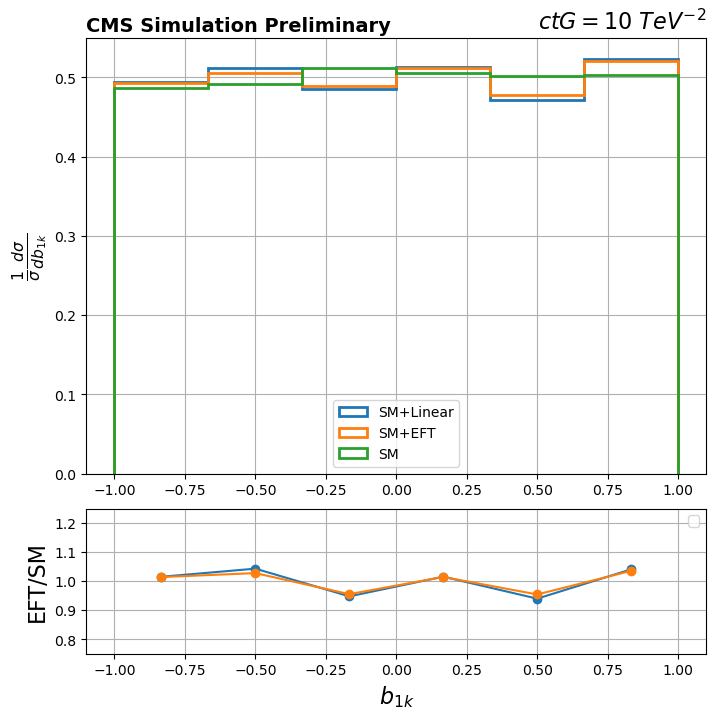

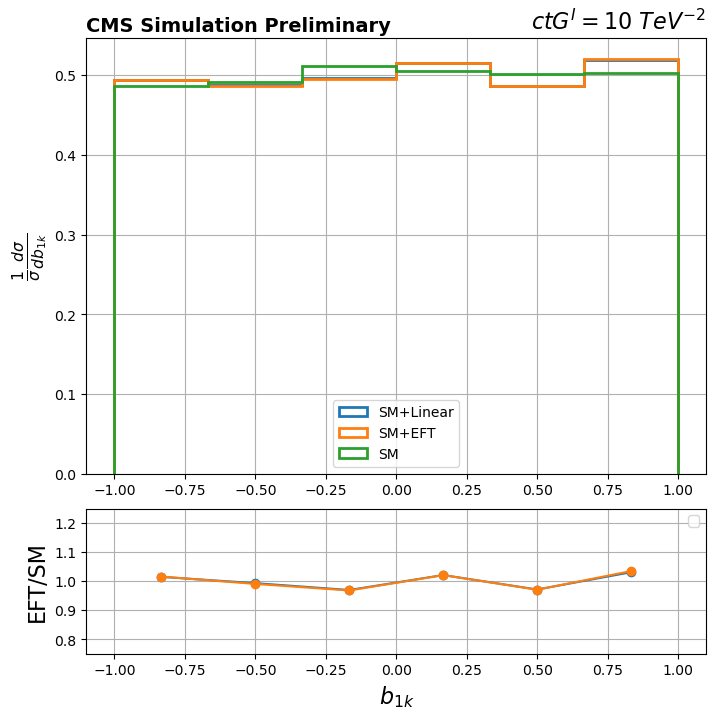

In [40]:
# Assuming gen_spincorr_vars is the output from spincorr_calc function
b1k = gen_spincorr_vars[0]
# Plot b1k with multiple sets of weights
plot_cms_style_norm(b1k, weights_list_R, labels, xlabel=r'$b_{1k}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{db_{1k}}$', title=r'$ctG=10\ TeV^{-2}$')
plot_cms_style_norm(b1k, weights_list_I, labels, xlabel=r'$b_{1k}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{db_{1k}}$', title=r'$ctG^I=10\ TeV^{-2}$')

/tmp/ipykernel_4806/3992530304.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_4806/3992530304.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


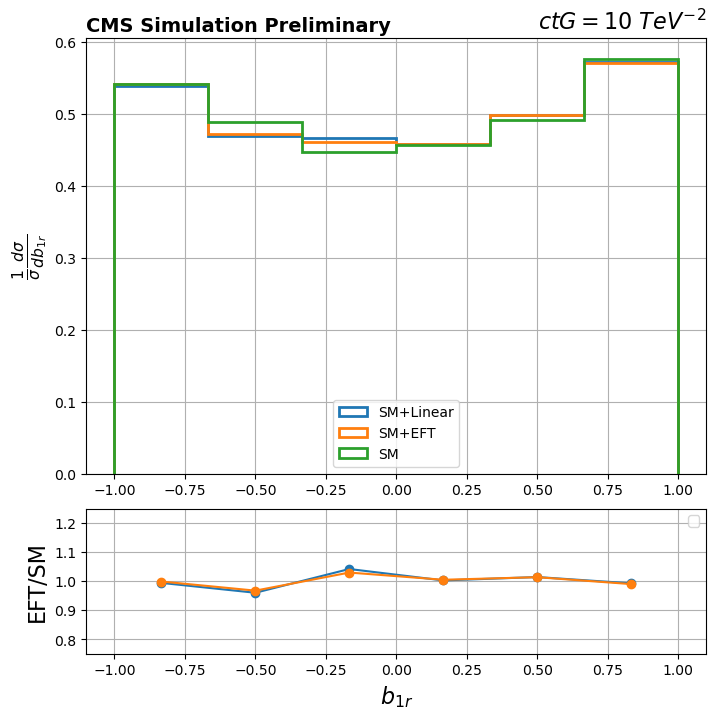

/tmp/ipykernel_4806/3992530304.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_4806/3992530304.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


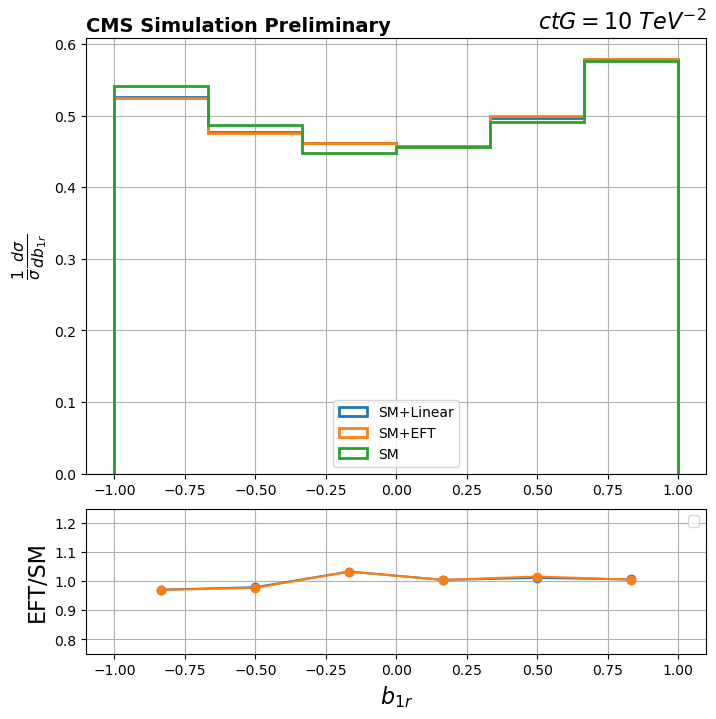

In [51]:
# Assuming gen_spincorr_vars is the output from spincorr_calc function
b1r = gen_spincorr_vars[2]
# Plot b1k with multiple sets of weights
plot_cms_style_norm(b1r, weights_list_R, labels, xlabel=r'$b_{1r}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{db_{1r}}$', title=r'$ctG=10\ TeV^{-2}$')
plot_cms_style_norm(b1r, weights_list_I, labels, xlabel=r'$b_{1r}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{db_{1r}}$', title=r'$ctG=10\ TeV^{-2}$')

/tmp/ipykernel_4806/1585550842.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_4806/1585550842.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


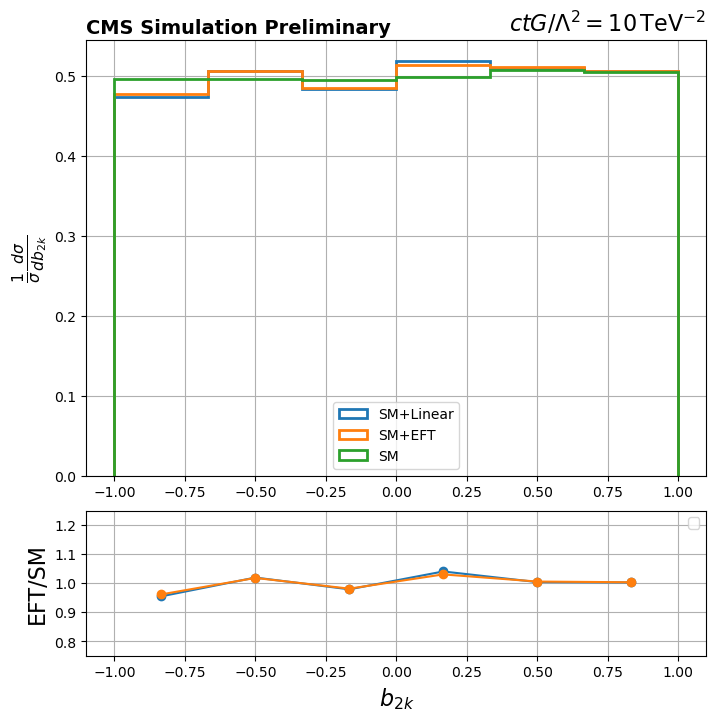

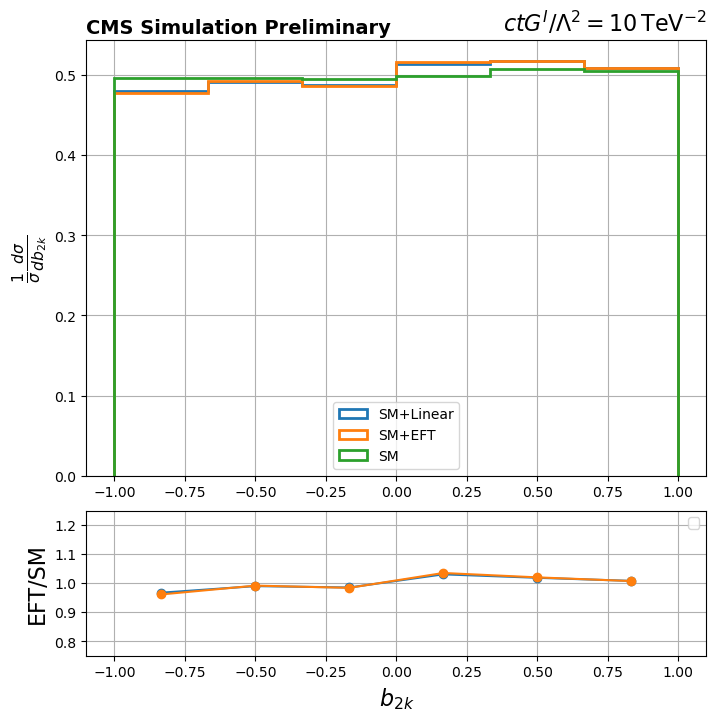

In [42]:
# Assuming gen_spincorr_vars is the output from spincorr_calc function
b2k = gen_spincorr_vars[1]

# Plot b1k with multiple sets of weights

plot_cms_style_norm(b2k, weights_list_R, labels, xlabel=r'$b_{2k}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{db_{2k}}$', title=r'$ctG/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')

plot_cms_style_norm(b2k, weights_list_I, labels, xlabel=r'$b_{2k}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{db_{2k}}$', title=r'$ctG^I/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')

/tmp/ipykernel_4806/3992530304.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_4806/3992530304.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


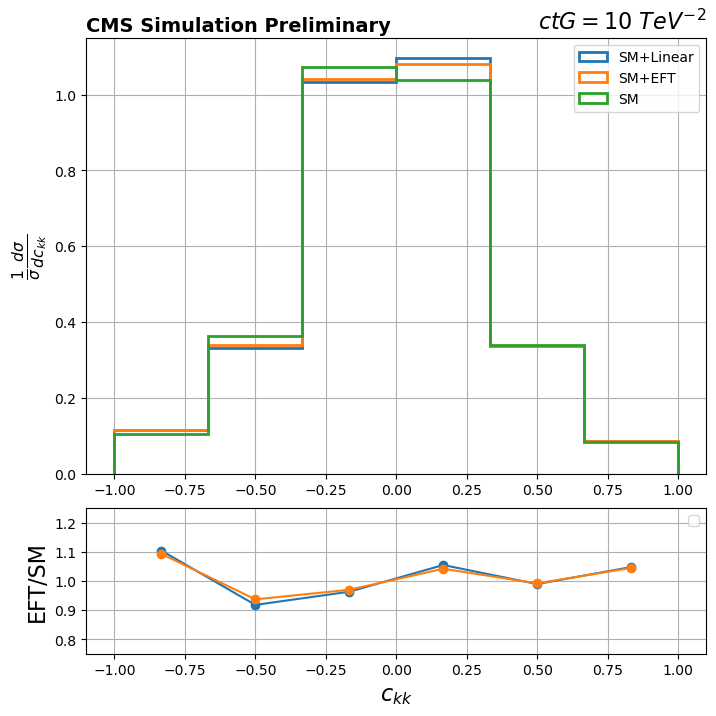

/tmp/ipykernel_4806/3992530304.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_4806/3992530304.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


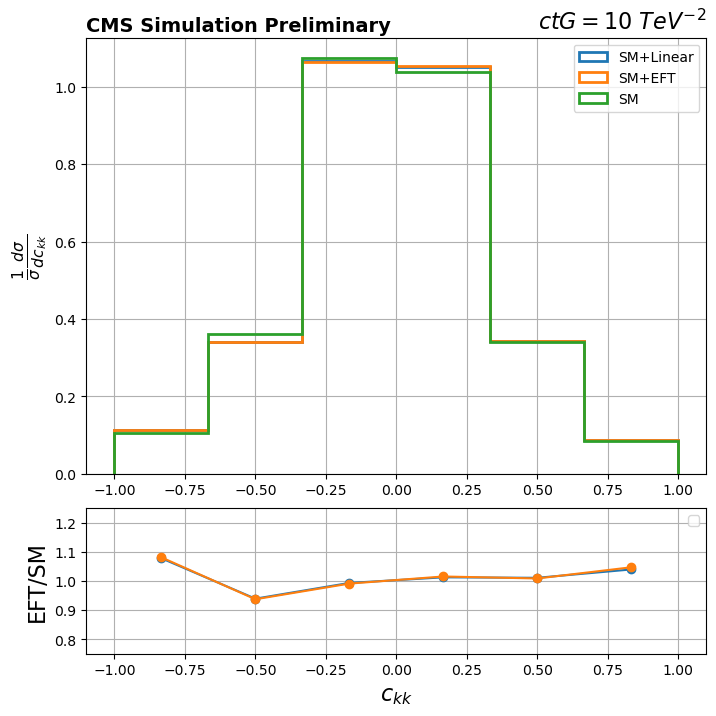

In [53]:
# Assuming gen_spincorr_vars is the output from spincorr_calc function
ckk = gen_spincorr_vars[6]

# Plot ckk with multiple sets of weights

plot_cms_style_norm(ckk, weights_list_R, labels, xlabel=r'$c_{kk}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{dc_{kk}}$', title=r'$ctG=10\ TeV^{-2}$')
plot_cms_style_norm(ckk, weights_list_I, labels, xlabel=r'$c_{kk}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{dc_{kk}}$', title=r'$ctG=10\ TeV^{-2}$')

/tmp/ipykernel_4806/1585550842.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_4806/1585550842.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


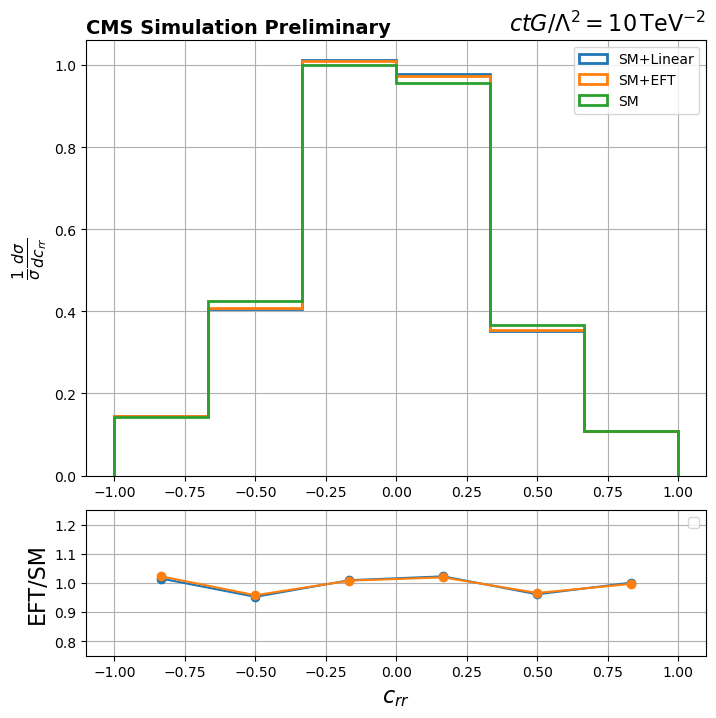

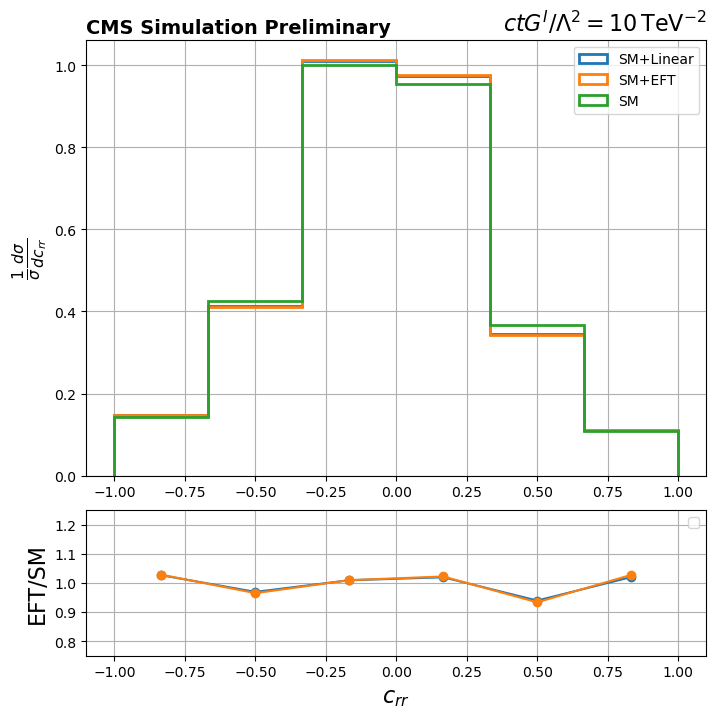

In [44]:
# Assuming gen_spincorr_vars is the output from spincorr_calc function
c_rr = gen_spincorr_vars[10]
plot_cms_style_norm(c_rr, weights_list_R, labels, xlabel=r'$c_{rr}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{dc_{rr}}$', title=r'$ctG/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')
plot_cms_style_norm(c_rr, weights_list_I, labels, xlabel=r'$c_{rr}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{dc_{rr}}$', title=r'$ctG^I/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')

/tmp/ipykernel_4806/1585550842.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_4806/1585550842.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


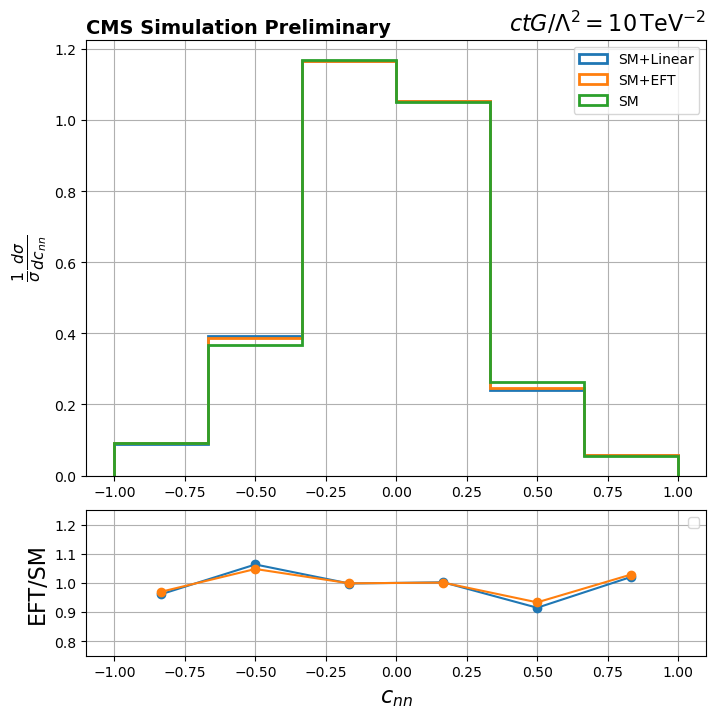

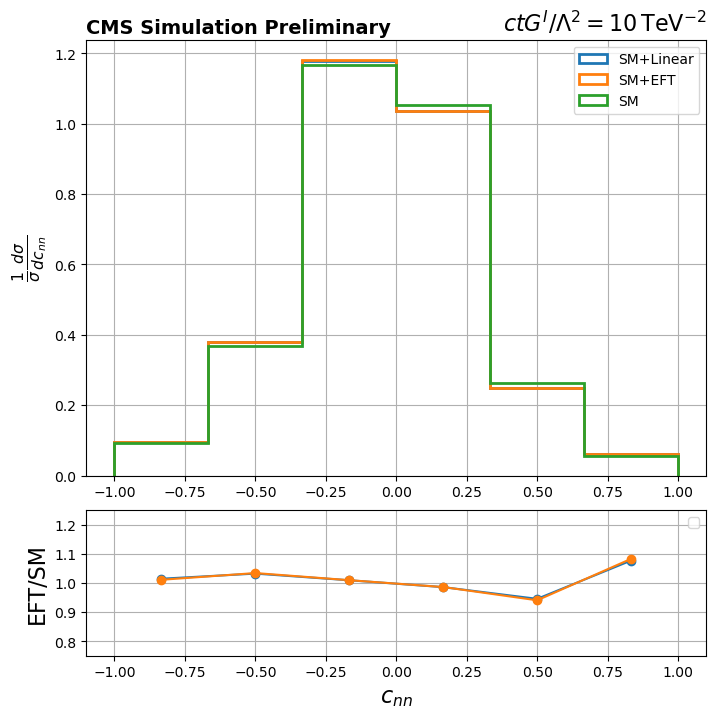

In [45]:
# Assuming gen_spincorr_vars is the output from spincorr_calc function
c_nn = gen_spincorr_vars[14]
# Plot b1k with multiple sets of weights
plot_cms_style_norm(c_nn, weights_list_R, labels, xlabel=r'$c_{nn}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{dc_{nn}}$', title=r'$ctG/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')
plot_cms_style_norm(c_nn, weights_list_I, labels, xlabel=r'$c_{nn}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{dc_{nn}}$', title=r'$ctG^I/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')

/tmp/ipykernel_4806/1585550842.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_4806/1585550842.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


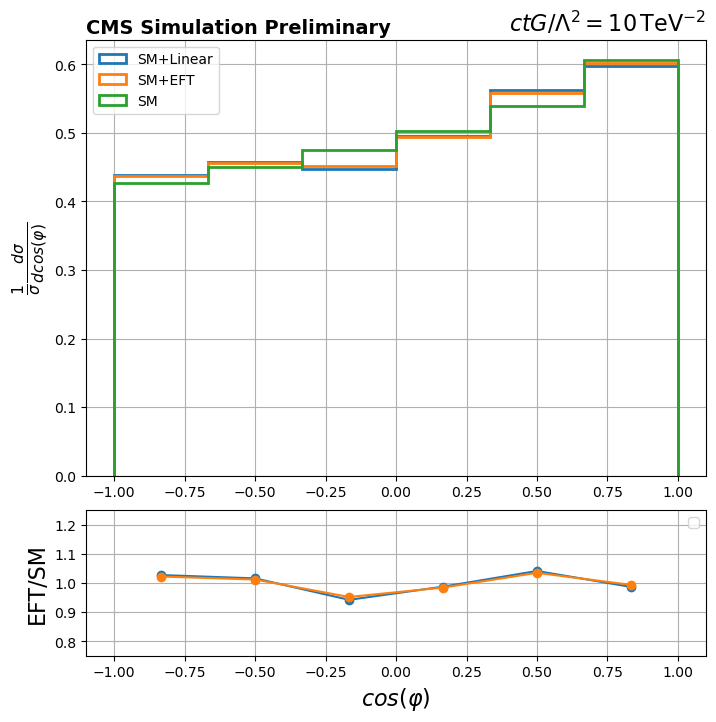

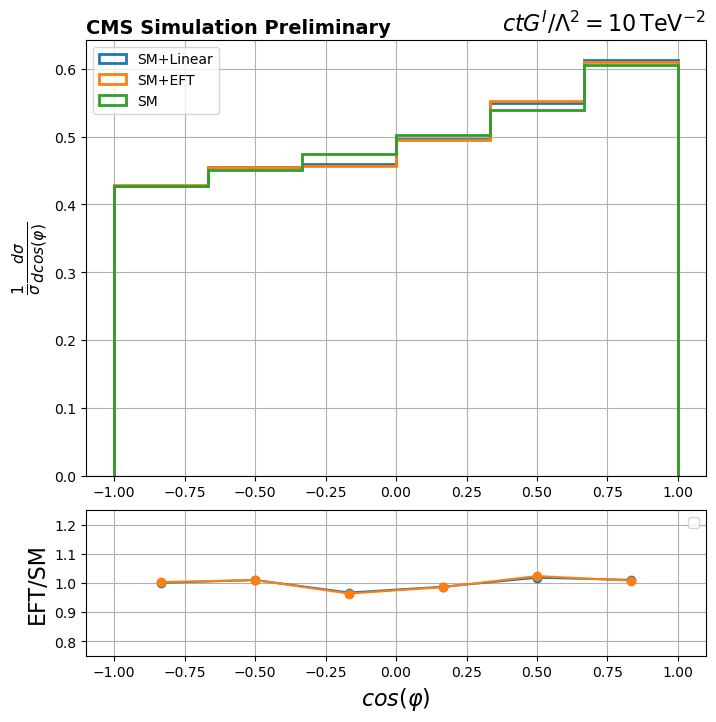

In [46]:
# Assuming gen_spincorr_vars is the output from spincorr_calc function
ll_cHel = gen_spincorr_vars[15]
plot_cms_style_norm(ll_cHel, weights_list_R, labels, xlabel=r'$cos(\varphi)$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{dcos(\varphi)}$', title=r'$ctG/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')
plot_cms_style_norm(ll_cHel, weights_list_I, labels, xlabel=r'$cos(\varphi)$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{dcos(\varphi)}$', title=r'$ctG^I/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')

/tmp/ipykernel_4806/1585550842.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_4806/1585550842.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


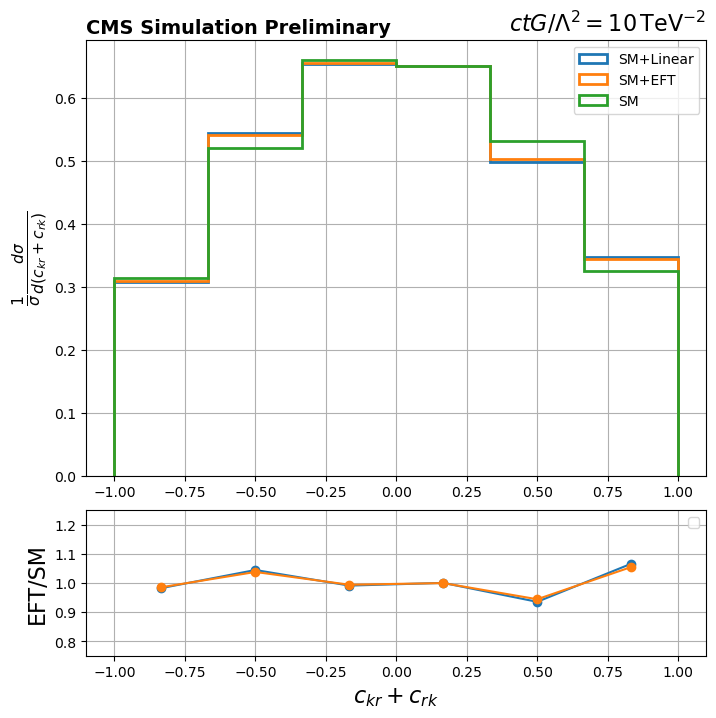

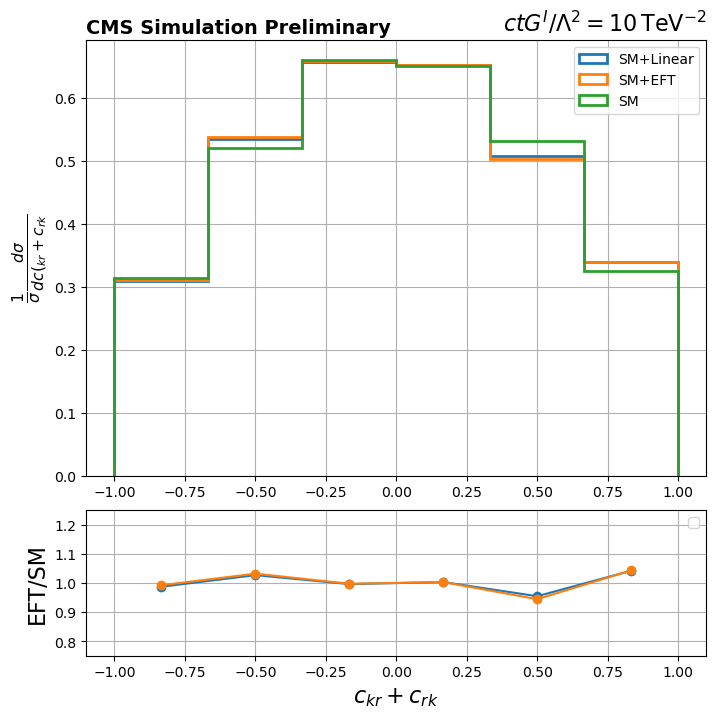

In [47]:
# Assuming gen_spincorr_vars is the output from spincorr_calc function
cp_kr = gen_spincorr_vars[19]
plot_cms_style_norm(cp_kr, weights_list_R, labels, xlabel=r'$c_{kr}+c_{rk}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{d(c_{kr}+c_{rk})}$', title=r'$ctG/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')
plot_cms_style_norm(cp_kr, weights_list_I, labels, xlabel=r'$c_{kr}+c_{rk}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{dc(_{kr}+c_{rk}}$', title=r'$ctG^I/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')

/tmp/ipykernel_4806/1585550842.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_4806/1585550842.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


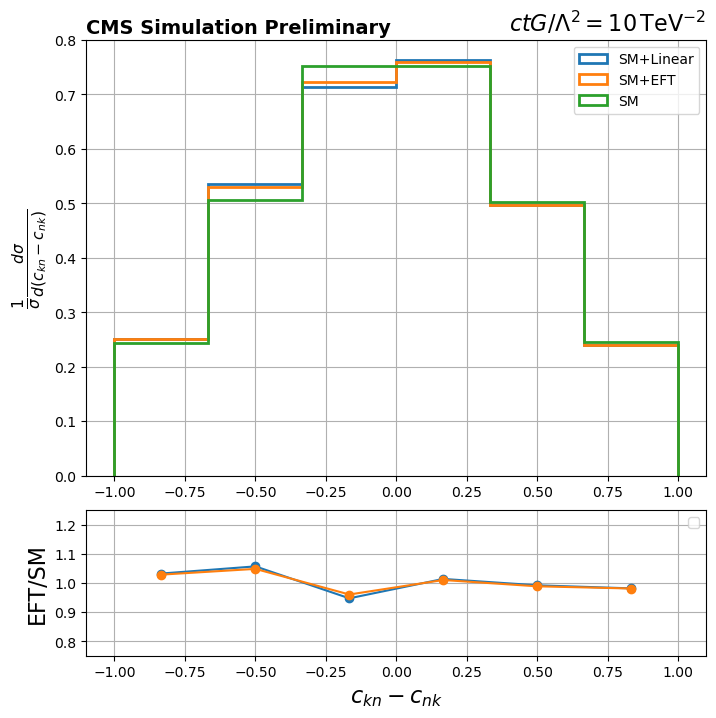

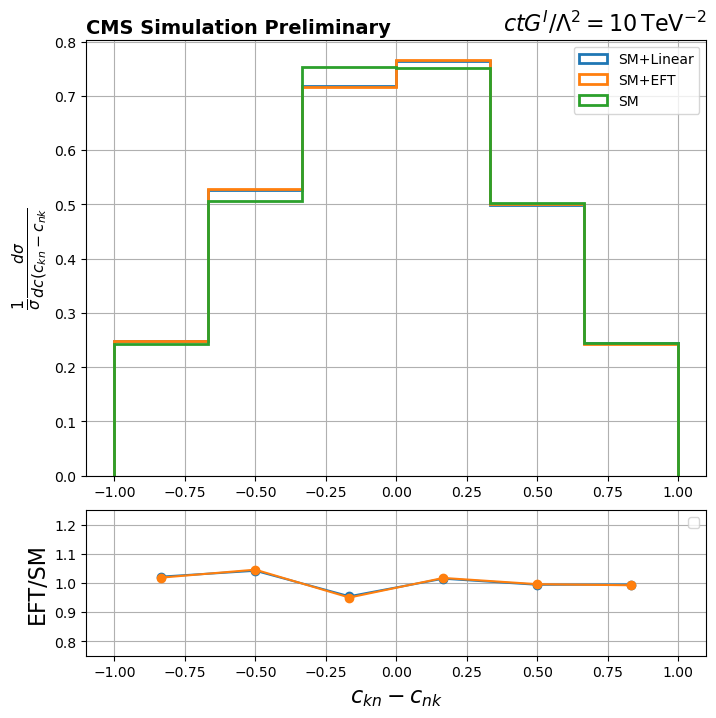

In [48]:
# Assuming gen_spincorr_vars is the output from spincorr_calc function
cm_kn = gen_spincorr_vars[22]
plot_cms_style_norm(cm_kn, weights_list_R, labels, xlabel=r'$c_{kn}-c_{nk}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{d(c_{kn}-c_{nk})}$', title=r'$ctG/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')
plot_cms_style_norm(cm_kn, weights_list_I, labels, xlabel=r'$c_{kn}-c_{nk}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{dc(c_{kn}-c_{nk}}$', title=r'$ctG^I/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')

/tmp/ipykernel_4806/1585550842.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_4806/1585550842.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


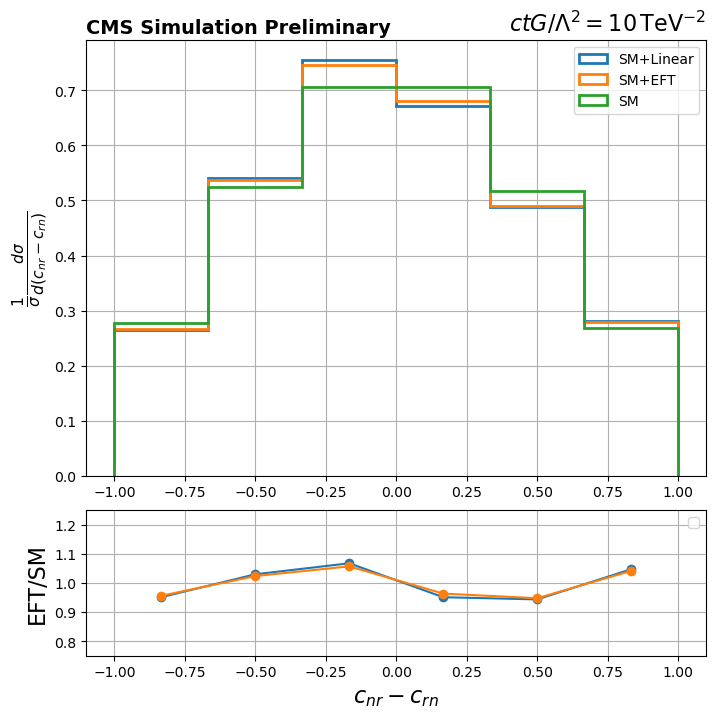

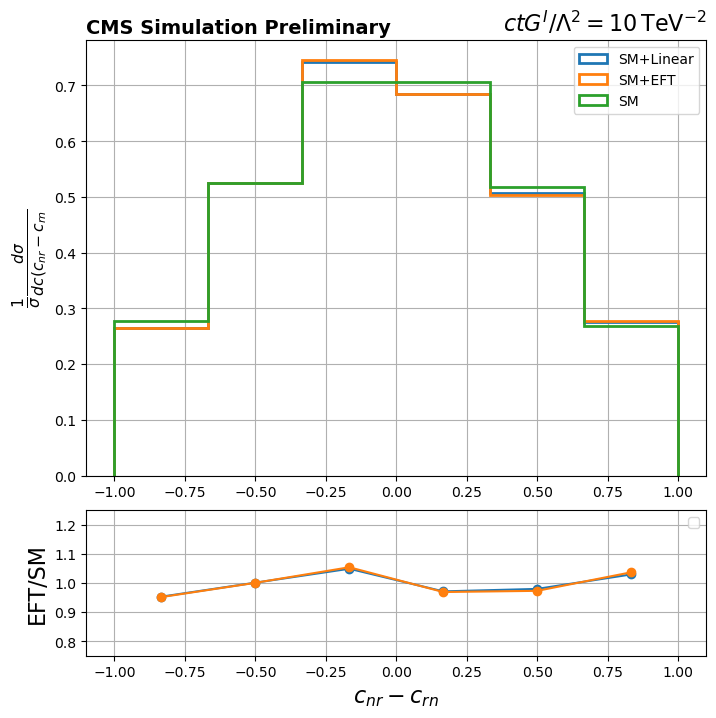

In [49]:
# Assuming gen_spincorr_vars is the output from spincorr_calc function
cm_kr = gen_spincorr_vars[24]
plot_cms_style_norm(cm_kr, weights_list_R, labels, xlabel=r'$c_{nr}-c_{rn}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{d(c_{nr}-c_{rn})}$', title=r'$ctG/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')
plot_cms_style_norm(cm_kr, weights_list_I, labels, xlabel=r'$c_{nr}-c_{rn}$', ylabel=r'$\frac{1}{\sigma}\frac{d\sigma}{dc(c_{nr}-c_{rn}}$', title=r'$ctG^I/\Lambda^2 = 10 \, \mathrm{TeV}^{-2}$')

In [224]:
ll_cHel[15]

<Array [0.939] type='1 * float64'>

In [ ]:
0: b1k
1: b2k
2: b1r
3: b2r
4: b1n
5: b2n
6: c_kk
7: c_kr
8: c_kn
9: c_rk
10: c_rr
11: c_rn
12: c_nk
13: c_nr
14: c_nn
15: ll_cHel
16: ll_delta_phi
17: ll_delta_eta
18: ll_delta_R
19: cP_kr
20: cM_kr
21: cP_kn
22: cM_kn
23: cP_rn
24: cM_rn


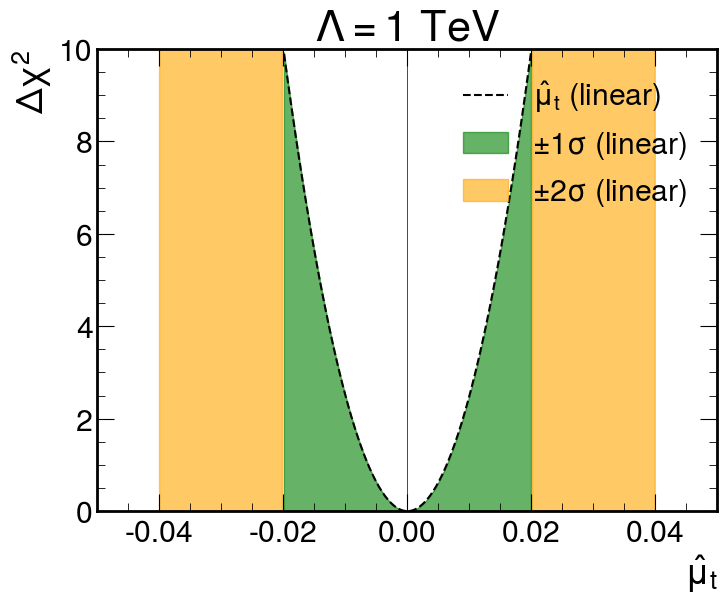

In [216]:
import numpy as np
import matplotlib.pyplot as plt

# Generate chi-square data
mu_t = np.linspace(-0.05, 0.05, 400)
chi2 = 10 * (mu_t / 0.02)**2  # Example parabola for chi2 vs mu_t

# Confidence intervals
mu_t_min = 0
chi2_min = 0
delta_chi2_1sigma = 1  # 1-sigma corresponds to a delta chi2 of 1
delta_chi2_2sigma = 4  # 2-sigma corresponds to a delta chi2 of 4

# Determine confidence intervals
mu_t_1sigma = 0.02  # Example 1-sigma value
mu_t_2sigma = 0.04  # Example 2-sigma value

# Plot
plt.figure(figsize=(8, 6))

# Plot chi-square curve
plt.plot(mu_t, chi2, 'k--', label=r'$\hat{\mu}_t$ (linear)')

# 1-sigma region
plt.fill_between(mu_t, 0, chi2, where=(abs(mu_t) <= mu_t_1sigma), color='green', alpha=0.6, label=r'$\pm 1\sigma$ (linear)')

# 2-sigma region
plt.fill_between(mu_t, 0, chi2, where=(abs(mu_t) <= mu_t_2sigma) & (abs(mu_t) > mu_t_1sigma), color='orange', alpha=0.6, label=r'$\pm 2\sigma$ (linear)')

# Plot settings
plt.xlabel(r'$\hat{\mu}_t$')
plt.ylabel(r'$\Delta \chi^2$')
plt.xlim(-0.05, 0.05)
plt.ylim(0, 10)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.legend(loc='best')
plt.title(r'$\Lambda = 1$ TeV')

# Show plot
plt.show()
